In [334]:
# ANALYSIS OF N ISOLATED SIMULATIONS OUTPUT DATA

# Works with yt 4.0 and Pythoon 3.10.6

# INITIALIZATION

# Import core modules
import numpy as np
import yt
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import math
import bisect as bsct
from mpl_toolkits.axes_grid1 import AxesGrid
import unyt
import h5py
import os.path
import copy
from scipy.stats import kde
import yt.extensions.astro_analysis.halo_analysis
from yt.frontends.halo_catalog.data_structures import HaloDataset

# Ignore yt logs
yt.set_log_level(0)

# HELPING FUNCTIONS

# Get the index of the closest but bigger element in a list than your value 
def getClosestIdx(myList, myNumber):
        return bsct.bisect_left(myList, myNumber)

# Get the idx of maximum number in iterable
def maxIdx(arr):
    maxAux = 0
    for i,el in enumerate(arr):
        if el > arr[maxAux]:
            maxAux = i
    return maxAux

# Get the n maximum numbers idx in iterable (ONLY SEND COPIES)
def findNmax(arr, N):
    minV = min(arr)
    maxes = [0]*N
    for i in range(N):
        max1 = maxIdx(arr)
        maxes[i] = max1
        arr[max1] = minV
    return maxes

# Calculate the actual center of a simulation snapshot
def findCenter(sim, snapshotN, lim=15.0):
    snap = sim[snapshotN]
    cutOff = snap.sphere("center",(lim,"kpc"))
    den = np.array(cutOff["PartType0", "Density"].to("Msun/pc**3"))
    x = np.array(cutOff["PartType0", "x"].to("pc"))
    y = np.array(cutOff["PartType0", "y"].to("pc"))
    z = np.array(cutOff["PartType0", "z"].to("pc"))
    cen = maxIdx(den)
    return [x[cen],y[cen],z[cen]]

# Centering calc2
def findCenter2(sim, snapshotN, lim=1.0):
    snap = sim[snapshotN]
    cutOff = snap.sphere("center",(lim,"kpc"))
    cen = cutOff.quantities.center_of_mass(use_gas=True, use_particles=False).in_units("pc")
    return cen.d

# Centering calc3 (like AGORA Paper)
def findCenter3(sim, snapshotN, lim=1.0):
    snap = sim[snapshotN]

    v, cen1 = snap.find_max(("gas", "density"))
    bigCutOff = snap.sphere(cen1, (30.0, "kpc"))
    cen2 = bigCutOff.quantities.center_of_mass(use_gas=True, use_particles=False).in_units("kpc")
    cutOff = snap.sphere(cen2,(1.0,"kpc"))
    cen = cutOff.quantities.max_location(("gas", "density"))

    return np.array([cen[1].d,cen[2].d,cen[3].d])*1e3

# Centering calc4 (AGORA paper hack)
def findCenter4(sim, snapshotN, lim=1.0):
    snap = sim[snapshotN]
    cen = snap.arr([6.184520935812296e+21, 4.972678132728082e+21, 6.559067311284074e+21], 'cm')
    cen = cen.to("pc")
    cen = np.array([cen[0].d,cen[1].d,cen[2].d])
    return cen

# Print a hdf5 file structure
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')
        
def h5print(filename):
    h5printR(filename, '  ')

# LOADING SCAFFOLDING
from dataclasses import dataclass, field
@dataclass
class particleList:
    # Global
    x:  np.ndarray = None
    y:  np.ndarray = None
    z:  np.ndarray = None
    m:  np.ndarray = None
    vx: np.ndarray = None
    vy: np.ndarray = None
    vz: np.ndarray = None

    r:  np.ndarray = None # Spherical r
    rc: np.ndarray = None # Cilyndrical r

    # Gas
    d:  np.ndarray = None
    h:  np.ndarray = None
    t:  np.ndarray = None
    mt: np.ndarray = None

@dataclass
class snapshot:
    idx   : int
    ytIdx : int
    time  : float

    p     : list       = field(default_factory=list)
    center: np.ndarray = None

@dataclass
class simul:
    name  : str
    ytFull: list = field(default_factory=list)

    snap  : list = field(default_factory=list)

# Load particle list for one snapshot
def loadParticles(sim,snapI,pI,typeP):
    # Load general
    sim.snap[snapI].p[pI]    = particleList()
    sim.snap[snapI].p[pI].x  = np.array(sim.ytFull[snapI].r[typeP, "Coordinates"].to("pc")  )[:,0]-sim.snap[snapI].center[0]
    sim.snap[snapI].p[pI].y  = np.array(sim.ytFull[snapI].r[typeP, "Coordinates"].to("pc")  )[:,1]-sim.snap[snapI].center[1]
    sim.snap[snapI].p[pI].z  = np.array(sim.ytFull[snapI].r[typeP, "Coordinates"].to("pc")  )[:,2]-sim.snap[snapI].center[2]
    sim.snap[snapI].p[pI].m  = np.array(sim.ytFull[snapI].r[typeP, "Masses"     ].to("Msun"))
    sim.snap[snapI].p[pI].vx = np.array(sim.ytFull[snapI].r[typeP, "Velocities" ].to("km/s"))[:,0]
    sim.snap[snapI].p[pI].vy = np.array(sim.ytFull[snapI].r[typeP, "Velocities" ].to("km/s"))[:,1]
    sim.snap[snapI].p[pI].vz = np.array(sim.ytFull[snapI].r[typeP, "Velocities" ].to("km/s"))[:,2]

    # Load specific
    if typeP == "PartType0":
        sim.snap[snapI].p[pI].d  = np.array(sim.ytFull[snapI].r[typeP, "Density"].to("Msun/pc**3"))
        sim.snap[snapI].p[pI].h  = np.array(sim.ytFull[snapI].r[typeP, "SmoothingLength"].to("pc"))
        if (typeP,"Temperature") in sim.ytFull[snapI].field_list:
            sim.snap[snapI].p[pI].t  = np.array(sim.ytFull[snapI].r[typeP, "Temperature"].to("K"))
        if (typeP,"Metallicity") in sim.ytFull[snapI].field_list:
            sim.snap[snapI].p[pI].mt = np.array(sim.ytFull[snapI].r[typeP, "Metallicity"])

# Load center for one snapshot
def loadCenters(sim,idx,rlim=20,fun="3"):
    methodDict = {"1":findCenter,"2":findCenter2,"3":findCenter3,"4":findCenter4}
    sim.snap[idx].center = np.array(methodDict[fun](sim.ytFull,idx,1.0))
    #sim.snap[idx].center = np.array(findCenter2(sim.ytFull,idx,rlim))

# Load one snapshot
def loadSnapshot(sim,idx,trueIdx,loadAllP=0,verboseLvl=1,sameCenter=0):
    # Initialize the snapshot struct
    sim.snap[idx] = snapshot(idx,trueIdx,float(sim.ytFull[idx].current_time.in_units("Myr")))
    if verboseLvl > 0: print("  - Loading snapshot",idx,"true index",sim.snap[idx].ytIdx,"at",sim.snap[idx].time,"Myr")
    if sameCenter != 0:
        sim.snap[idx].center = np.array(sameCenter)
    else:
        loadCenters(sim,idx)
    if verboseLvl > 1: print("    Center initialized at",sim.snap[idx].center,"pc")

    # Load each type of particle
    if loadAllP:
        nParts = sum(np.array(sim.ytFull[idx].parameters["NumPart_ThisFile"]) > 0)
        typeP = ["PartType"+str(i) for i in range(nParts)]
        sim.snap[idx].p = [None]*len(typeP)
        for i in range(len(typeP)):
            if verboseLvl > 2: print("    - Loading",typeP[i])
            loadParticles(sim,idx,i,typeP[i])

# Load a full simulation
def loadSim(sim,ytData,allowedSnaps=0,loadAllP=0,verboseLvl=1,sameCenter=0):
    print("\n--Started loading simulation",sim.name)
    
    print("Loading from yt file:",ytData)
    # Load only some snapshots if desired
    if allowedSnaps != 0:
        sim.ytFull = [None]*len(allowedSnaps)
        print("  Loading only snapshots:",allowedSnaps)
        for i in range(len(allowedSnaps)):
            sim.ytFull[i] = ytData[allowedSnaps[i]]
            if verboseLvl > 1: print("    Loaded yt snapshot",i,"from file:",ytData[allowedSnaps[i]])
    else:
        sim.ytFull = [None]*len(ytData)
        ytStr = [None]*len(ytData)
        for i in range(len(ytData)):
            ytStr[i] = str(ytData[i].filename)[-8:-5]
        print("  Loading all snapshots found",ytStr)    
        for i in range(len(ytData)):
            sim.ytFull[i] = ytData[i]
            if verboseLvl > 1: print("    Loaded yt snapshot",i,"from file:",ytData[i])

    sim.snap = [None]*len(sim.ytFull)
    for i in range(len(sim.ytFull)):
        sim.ytFull[i].hubble_constant  = 0.71
        sim.ytFull[i].omega_lambda     = 0.73
        sim.ytFull[i].omega_matter     = 0.27
        sim.ytFull[i].omega_curvature  = 0.0
        sim.ytFull[i].current_redshift = 0.0

        trueIdx = i
        if allowedSnaps != 0:
            trueIdx = allowedSnaps[i]
        loadSnapshot(sim,i,trueIdx,loadAllP=loadAllP,verboseLvl=verboseLvl,sameCenter=sameCenter)

# Gets the idx of the snapshot with the time closest to the one inputted
def tToIdx(sim,time):
    dist = abs(sim.snap[0].time-time)
    idx = 0
    for i in range(len(sim.snap)):
        nDist = abs(sim.snap[i].time-time)
        if nDist < dist:
            dist = nDist
            idx = i
    return idx


In [345]:
# LOADING DATA
gadget_base = {'UnitLength_in_cm': 3.08568e+21, 'UnitMass_in_g': 1.989e+43,	'UnitVelocity_in_cm_per_s': 100000}
def customLoad(path,unitBase=gadget_base,bbox=[[-2000.0, 2000.0], [-2000.0, 2000.0], [-2000.0, 2000.0]]):
    res = yt.load(path,unit_base=unitBase,bounding_box=bbox)
    return res

ytG4nsff  = customLoad("C:\Home\LinuxShare\AGORA_iGalaxy_noSFFupdate1\snapshot_???.hdf5")    # G4 nSFF updated with G3 params
ytG4sff   = customLoad("C:\Home\LinuxShare\AGORA_iGalaxy_SFFupdate1\snapshot_???.hdf5")      # G4 SFF with G3 parameters and metal diffusion
G4nsff = simul("GADGET4 nSFF")
G4sff  = simul("GADGET4 SFF")
loadSim(G4nsff,ytG4nsff,verboseLvl=10,allowedSnaps=[0,50])
loadSim(G4sff,ytG4sff,verboseLvl=10,allowedSnaps=[0,50])

ytG3nsff  = customLoad("C:\Home\Astro\AGORA\isolated\G3 data\snap_iso_dry_0??.hdf5")    # G3 nSFF 
ytG3sff   = customLoad("C:\Home\Astro\AGORA\isolated\G3 data\snap_iso_sf_0??.hdf5")     # G3 SFF 
G3nsff = simul("GADGET3 nSFF")
G3sff  = simul("GADGET3 SFF")
loadSim(G3nsff,ytG3nsff,verboseLvl=10,allowedSnaps=[0,1])
loadSim(G3sff,ytG3sff,verboseLvl=10,allowedSnaps=[0,1])

ytG4sffHsml   = customLoad("C:\Home\LinuxShare\AGORA_iGalaxy_SFFmingas\snapshot_???.hdf5")   # G4 SFF with G3 parameters, metal diffusion and 1.0 mingashsml
G4sffHsml  = simul("GADGET4 SFF 1HSML")
loadSim(G4sffHsml,ytG4sffHsml,verboseLvl=10,allowedSnaps=[0,50])


--Started loading simulation GADGET4 nSFF
Loading from yt file: <yt.data_objects.time_series.DatasetSeries object at 0x000001832CF41C30>
  Loading only snapshots: [0, 50]
    Loaded yt snapshot 0 from file: snapshot_000
    Loaded yt snapshot 1 from file: snapshot_050
  - Loading snapshot 0 true index 0 at 0.0 Myr
    Center initialized at [-85.08359641  88.21381629  13.73616979] pc
  - Loading snapshot 1 true index 50 at 488.89649402996423 Myr
    Center initialized at [ 25.30841343 236.54933274 392.537117  ] pc

--Started loading simulation GADGET4 SFF
Loading from yt file: <yt.data_objects.time_series.DatasetSeries object at 0x000001832FC00220>
  Loading only snapshots: [0, 50]
    Loaded yt snapshot 0 from file: snapshot_000
    Loaded yt snapshot 1 from file: snapshot_050
  - Loading snapshot 0 true index 0 at 0.0 Myr
    Center initialized at [-85.08359641  88.21381629  13.73616979] pc
  - Loading snapshot 1 true index 50 at 488.89649402996423 Myr
    Center initialized at [228.

In [348]:
# CONFIG OPTIONS AND FIELD INITIALIZATION

# Simulation chooser
#sims     = [G4nsff,G3nsff,G4sff,G3sff]
#simsSFF  = [G3sff,G4sff]
#simsNSFF = [G3nsff,G4nsff]

sims     = [G4sff,G4sffHsml]
simsSFF  = [G4sff,G4sffHsml]

# Gives the indices for choosing the snapshot to be analised in each simulation (can also be customised for other times)
timePlot= 500 # Myr
idx     = [tToIdx(sn,timePlot) for sn in sims]
idxSFF  = [tToIdx(sn,timePlot) for sn in simsSFF]
#idxNSFF = [tToIdx(sn,timePlot) for sn in simsNSFF]

# Figure options
figSize   = 8  # Fig size for plt plots
ytFigSize = 6  # Window size for the yt plot
fontSize  = 12 # Fontsize in yt plots

# Modified color maps
mColorMap = copy.copy(plt.get_cmap('algae'))
mColorMap.set_bad(mColorMap(0.347)) # (0.02041 - 0.01) / (0.04 - 0.01) = 0.347
mColorMap.set_under(mColorMap(0))
mColorMap2 = copy.copy(plt.get_cmap('algae'))
mColorMap2.set_bad(mColorMap2(0))
mColorMap2.set_under(mColorMap2(0))

# Scaffolding options (Global parameters for how the plotting functions below should operate)
verboseLevel    = 15                    # How detailed is the console log, higher is more detailed
showErrorGlobal = 1                     # If the dispersion is plotted or not
errorLimGlobal  = (-1,1)                # Y limits on the dispersion plot
showAll         = True                  # If the plots are showed in the notebook or not
saveAll         = True                  # If the plots are saved to disk or not
savePath        = "Figures\\fiducial_hsml\\" # Folder where the plots are saved

# Analysis options
figWidth     = 30          # Kpc (Galatic diameter, to be considered when restricting which particles to analize)
buffSize     = 375         # N   (Default bin number for coordinate-type histograms) 
youngStarAge = 20          # Myr (Age to be considered for SFR density calculations)
lowResMock   = 750         # pc  (Resolution of the mock observations)
gasPart      = "PartType0" # Field for gas SPH particles 
starPart     = "PartType4" # Field for star particles

# Derived options
binSize      = int(figWidth*1e3/lowResMock) # Bin size calculated for mock observations

# ADD NEW FIELDS
# Types of simulations for array ordering
snapArrFull  = [sims[i].ytFull[idx[i]] for i in range(len(sims))]
snapArrSFF   = [simsSFF[i].ytFull[idxSFF[i]] for i in range(len(simsSFF))]
#snapArrNSFF  = [simsNSFF[i].ytFull[idxNSFF[i]] for i in range(len(simsNSFF))]

# Simple fields
def _density_squared(field, data):  
	return data[(gasPart, "Density")]**2
def _res(field, data):  
    return (data[(gasPart, "Masses")]/data[(gasPart, "Density")])**(1./3.)
def _inv_vol_sq(field, data):  
    return (data[(gasPart, "Masses")]/data[(gasPart, "Density")])**(-2)
def _particle_position_cylindrical_z_abs(field, data):
    return np.abs(data[(gasPart, "particle_position_cylindrical_z")])

# Adding the fields
for i,snap in enumerate(snapArrFull):
    # Snapshot depending fields
    def _elevation(field, data):  
        return data[(gasPart, "particle_position_z")].in_units('kpc') - unyt.kpc*sims[i].snap[idx[i]].center[2]/1e3
    def _x_centered(field, data):
        return data[(gasPart, "particle_position_x")].in_units('kpc') - unyt.kpc*sims[i].snap[idx[i]].center[0]/1e3
    def _y_centered(field, data):
        return data[(gasPart, "particle_position_y")].in_units('kpc') - unyt.kpc*sims[i].snap[idx[i]].center[1]/1e3
    def _den_low_res(field,data):
        trans = np.zeros(data[(gasPart, "particle_mass")].shape)
        ind = np.where(data[(gasPart, "particle_mass")] > 0) 
        trans[ind] = data[(gasPart, "particle_mass")][ind].in_units('Msun').d/(lowResMock**2)
        return data.ds.arr(trans, "Msun/pc**2").in_base(data.ds.unit_system.name)
    
    snap.add_field((gasPart, "density_squared"), function=_density_squared, units="g**2/cm**6", sampling_type="particle",force_override=True)
    snap.add_field((gasPart, "elevation"), function=_elevation, units="kpc", sampling_type="particle", display_name="Elevation",force_override=True,take_log=False)
    snap.add_field((gasPart, "resolution"), function=_res, units="pc", sampling_type="particle", display_name="Resolution $\Delta$ x",force_override=True,take_log=True)
    snap.add_field((gasPart, "inv_volume_sq"), function=_inv_vol_sq, units="pc**(-6)", sampling_type="particle", display_name="Inv squared volume",force_override=True,take_log=True)
    snap.add_field((gasPart, "z_abs"), function=_particle_position_cylindrical_z_abs, take_log=False,units="cm",sampling_type="particle",force_override=True) 
    snap.add_field((gasPart, "x_centered"), function=_x_centered,display_name="x",units="kpc",sampling_type="particle",force_override=True,take_log=False) 
    snap.add_field((gasPart, "y_centered"), function=_y_centered,display_name="y",units="kpc",sampling_type="particle",force_override=True,take_log=False) 
    snap.add_field((gasPart, "den_low_res"), function=_den_low_res,display_name="Density",units="Msun/pc**2",sampling_type="particle",force_override=True,take_log=False) 

# Adding the SFF fields
for i,snap in enumerate(snapArrSFF):
    def _youngStar_Mass(field, data):  
        trans = np.zeros(data[(starPart, "particle_mass")].shape)
        ind = np.where(data[(starPart, "StellarFormationTime")]*1e3 > (snap.current_time.in_units('Myr').d - youngStarAge)) 
        trans[ind] = data[(starPart, "particle_mass")][ind].in_units('code_mass')
        return data.ds.arr(trans, "code_mass").in_base(data.ds.unit_system.name)
    def _x_centered(field, data):
        return data[(starPart, "particle_position_x")].in_units('kpc') - unyt.kpc*simsSFF[i].snap[idxSFF[i]].center[0]/1e3
    def _y_centered(field, data):
        return data[(starPart, "particle_position_y")].in_units('kpc') - unyt.kpc*simsSFF[i].snap[idxSFF[i]].center[1]/1e3
    def _sfr_den_low_res(field,data):
        trans = np.zeros(data[(starPart, "particle_mass")].shape)
        ind = np.where(data[(starPart, "StellarFormationTime")]*1e3 > (snap.current_time.in_units('Myr').d - youngStarAge)) 
        trans[ind] = data[(starPart, "particle_mass")][ind].in_units('Msun').d/((lowResMock/1e3)**2)/(youngStarAge*1e6)
        return data.ds.arr(trans, "Msun/yr/kpc**2").in_base(data.ds.unit_system.name)
        	
    snap.add_field((starPart, "particle_mass_young_stars"),function=_youngStar_Mass,display_name="Young Stellar Mass",units="code_mass",sampling_type="particle",force_override=True,take_log=True)
    snap.add_field((starPart, "x_centered"), function=_x_centered,display_name="x",units="kpc",sampling_type="particle",force_override=True,take_log=False) 
    snap.add_field((starPart, "y_centered"), function=_y_centered,display_name="y",units="kpc",sampling_type="particle",force_override=True,take_log=False) 
    snap.add_field((starPart, "sfr_den_low_res"), function=_sfr_den_low_res,display_name="SFR Density",units="Msun/yr/kpc**2",sampling_type="particle",force_override=True,take_log=False) 


In [353]:
# PLOTTING MACRO FUNCTIONS (rerun whenever config options are changed for new defaults)

# Plots field projections, defaults to standard density projection
def ytProjPanel(simArr, idxArr, verbose=verboseLevel, plotSize=ytFigSize, saveFig=saveAll, saveFigPath=0, showFig=showAll,
                message=0, twoAxis=True, axisProj = ["z","x"], part = "PartType0", bSize=buffSize, zField = "Density",
                zFieldUnit = "g/cm**2", cM = "algae",takeLog=1, zFieldLim = (1e-5,1e-1), zWidth=figWidth, fsize=fontSize,
                wField=0, ovHalo=0):
    if message != 0: print(message)

    # Option setup
    axNum = 1
    if twoAxis: axNum = 2

    # Panel fig setup
    panelSize = (axNum, len(simArr))
    panelFig = plt.figure()
    panelGrid = AxesGrid(panelFig,(0,0,1,1),nrows_ncols=panelSize,axes_pad=0.1,label_mode="1",share_all=True,cbar_location="right",cbar_mode="single",cbar_size="5%",cbar_pad="2%")

    # Loading snapshots
    snapArr  = [simArr[i].ytFull[idxArr[i]] for i in range(len(simArr))]
    titleArr = [simArr[i].name              for i in range(len(simArr))]

    # Start of the fig making
    if verbose > 9: print("  Setup complete - Starting fig making for",zField)
    for i,snap in enumerate(snapArr):
        if verbose > 9: print("  - Projecting",simArr[i].name,"at time",simArr[i].snap[idxArr[i]].time,"Myr")

        # Sets plotting options as detailed
        if verbose > 11: print("    Projecting in axis",axisProj[0])
        if takeLog == 0: snap.field_info[(part, zField)].take_log = False
        if wField != 0:
            fig1 = yt.ProjectionPlot(snap, axisProj[0], (part, zField), window_size=plotSize, weight_field=(part,wField), fontsize=fsize, center=simArr[i].snap[idxArr[i]].center/1000)
        else:
            if part=="PartType4":
                fig1 = yt.ParticleProjectionPlot(snap, axisProj[0], (part, zField), window_size=plotSize, depth=(zWidth,"kpc"), fontsize=fsize, center=simArr[i].snap[idxArr[i]].center/1000)
            else:
                fig1 = yt.ProjectionPlot(snap, axisProj[0], (part, zField), window_size=plotSize, fontsize=fsize, center=simArr[i].snap[idxArr[i]].center/1000)
        fig1.set_width(zWidth,"kpc")
        if zFieldUnit != 0: fig1.set_unit((part, zField), zFieldUnit)
        if zFieldLim != 0:  fig1.set_zlim((part, zField), zmin=zFieldLim[0], zmax=zFieldLim[1])
        fig1.set_cmap(field=(part, zField), cmap=cM)
        fig1.set_buff_size(bSize)

        # Plots a second axis if specified
        if twoAxis:
            if verbose > 11: print("    Projecting in axis",axisProj[1])
            if wField != 0:
                fig2 = yt.ProjectionPlot(snap, axisProj[1], (part, zField), window_size=plotSize, weight_field=(part,wField), fontsize=fsize, center=simArr[i].snap[idxArr[i]].center/1000) 
            else:
                if part=="PartType4":
                    fig2 = yt.ParticleProjectionPlot(snap, axisProj[1], (part, zField), window_size=plotSize, depth=(zWidth,"kpc"), fontsize=fsize, center=simArr[i].snap[idxArr[i]].center/1000)
                else:
                    fig2 = yt.ProjectionPlot(snap, axisProj[1], (part, zField), window_size=plotSize, fontsize=fsize, center=simArr[i].snap[idxArr[i]].center/1000)

            fig2.set_width(zWidth,"kpc")
            if zFieldUnit != 0: fig2.set_unit((part, zField), zFieldUnit)
            if zFieldLim != 0:  fig2.set_zlim((part, zField), zmin=zFieldLim[0], zmax=zFieldLim[1])
            fig2.set_cmap(field=(part, zField), cmap=cM)
            fig2.set_buff_size(bSize)

        # Transfers yt plot to plt axes and renders the figure
        if verbose > 11: print("    Rendering",simArr[i].name)
        fullPlot = fig1.plots[part, zField]
        fullPlot.figure = panelFig
        fullPlot.axes = panelGrid[i].axes
        fullPlot.cax = panelGrid.cbar_axes[i]
        if twoAxis:
            fullPlot2 = fig2.plots[part, zField]
            fullPlot2.figure = panelFig
            fullPlot2.axes = panelGrid[len(simArr)+i].axes
            fullPlot2.cax = panelGrid.cbar_axes[len(simArr)+i]
            fig2.render()
            
        fig1.render()

        # Overplot halos if prompted to and passed
        if ovHalo != 0:
            if verbose > 10: print("    Overplotting halos")
            haloData = ovHalo[0][i]
            haloFilt = ovHalo[1]
            xc = np.array(haloData['particle_position_x'][haloFilt[i]].in_units("kpc"))-simArr[i].snap[idxArr[i]].center[0]/1000
            yc = np.array(haloData['particle_position_y'][haloFilt[i]].in_units("kpc"))-simArr[i].snap[idxArr[i]].center[1]/1000
            zc = np.array(haloData['particle_position_z'][haloFilt[i]].in_units("kpc"))-simArr[i].snap[idxArr[i]].center[2]/1000
            rc = np.array(haloData['virial_radius'][haloFilt[i]].in_units("kpc"))

            for j in range(len(xc)):
                panelGrid.axes_all[i].add_patch(plt.Circle((xc[j],yc[j]),rc[j],ec="r",fc="none"))
                if twoAxis:
                    panelGrid.axes_all[len(simArr)+i].add_patch(plt.Circle((yc[j],zc[j]),rc[j],ec="r",fc="none"))

        # Sets title
        panelGrid.axes_all[i].set_title(titleArr[i])
    
    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        panelFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)
    
# Plots phase space 2D histograms, defaults to gas phase (Density, Temperature, Mass)
def ytPhasePanel(simArr, idxArr, depositionAlg="ngp", verbose=verboseLevel, plotSize=ytFigSize, saveFig=saveAll,
                 saveFigPath=0, showFig=showAll,message=0, blackLine=0, panOver=0, part = "PartType0", zLog=1,
                 zFields = ["Density","Temperature","Masses"], zFieldUnits = ["g/cm**3","K","Msun"], cM = "algae",
                 zFieldLim = (1e3,1e8,1e-29,1e-21,10,1e7), zWidth=15, fsize=12, wField=0, xb=300, yb=300, grid=True):
    if message != 0: print(message)
    # Panel fig setup
    if panOver == 0:
        panelSize = (1, math.ceil(len(simArr)))
    else:
        panelSize = panOver
    panelFig = plt.figure(figsize=(1,1))
    panelGrid = AxesGrid(panelFig,(0,0,0.4*panelSize[1],0.4*panelSize[0]),aspect=False,nrows_ncols=panelSize,axes_pad=0.1,
                         label_mode="1",share_all=True,cbar_location="right",cbar_mode="single",cbar_size="5%",cbar_pad="2%")
    
    if zFieldLim   == 0: zFieldLim   = [0,0,0,0,0,0]
    if zFieldUnits == 0: zFieldUnits = [0,0,0]

    # Loading snapshots
    snapArr  = [simArr[i].ytFull[idxArr[i]] for i in range(len(simArr))]
    titleArr = [simArr[i].name              for i in range(len(simArr))]

    # Getting the black line
    if blackLine:
        if verbose > 10: print("  Calculating avg profile with",simArr[0].name)
        sp = snapArr[0].sphere(simArr[0].snap[idxArr[0]].center/1e3,(zWidth,"kpc"))

        p1 = yt.ProfilePlot(sp,(part,"Density"),(part,"Temperature"),weight_field=(part,"Masses"), n_bins=30, x_log=False, accumulation=False)
        p1.set_log((part,zFields[0]),True)
        p1.set_log((part,zFields[1]),True)

        if zFieldUnits[0] != 0: p1.set_unit((part,zFields[0]), zFieldUnits[0])
        if zFieldLim[2] != 0 or zFieldLim[3] != 0: p1.set_xlim(zFieldLim[2], zFieldLim[3])
        if zFieldUnits[1] != 0: p1.set_unit((part,zFields[1]), zFieldUnits[1])

        cil = p1.profiles[0].x.in_units(zFieldUnits[0]).d
        bin = p1.profiles[0]["Temperature"].in_units(zFieldUnits[1]).d
        goodbin = []
        goodcil = []
        for i in range(len(bin)):
            if abs(bin[i]) > 1e-33:
                goodbin.append(bin[i]) 
                goodcil.append(cil[i])
           
    # Start of the fig making
    for i,snap in enumerate(snapArr):
        if verbose > 9: print("  - Plotting",simArr[i].name)
        sp = snap.sphere(simArr[i].snap[idxArr[i]].center/1e3,(zWidth,"kpc"))
        # Plot phase with specified parameters
        if zLog != 1:
            snap.field_info[(part, zFields[2])].take_log = False
        
        if wField != 0:
            fig1 = yt.ParticlePhasePlot(sp,  (part, zFields[0]),(part, zFields[1]),(part, zFields[2]), deposition=depositionAlg,
                                         figure_size=plotSize, weight_field=(part,wField), fontsize=fsize, x_bins=xb, y_bins=yb)
        else:
            fig1 = yt.ParticlePhasePlot(sp,  (part, zFields[0]),(part, zFields[1]),(part, zFields[2]), deposition=depositionAlg,
                                         figure_size=plotSize, fontsize=fsize, x_bins=xb, y_bins=yb)
        
        if zFieldUnits[0] != 0: fig1.set_unit((part, zFields[0]), zFieldUnits[0])
        if zFieldUnits[1] != 0: fig1.set_unit((part, zFields[1]), zFieldUnits[1])
        if zFieldUnits[2] != 0: fig1.set_unit((part, zFields[2]), zFieldUnits[2])
            
        if zFieldLim[0] != 0 or zFieldLim[1] != 0: fig1.set_zlim((part, zFields[2]), zmin=zFieldLim[0], zmax=zFieldLim[1])
        if zFieldLim[2] != 0 or zFieldLim[3] != 0: fig1.set_xlim(zFieldLim[2], zFieldLim[3])
        if zFieldLim[4] != 0 or zFieldLim[5] != 0: fig1.set_ylim(zFieldLim[4], zFieldLim[5])

        fig1.set_log((part,zFields[2]),bool(zLog))

        fig1.set_cmap(field=(part, zFields[2]), cmap=cM)

        # Transfers yt plot to plt axes and renders the figure
        if verbose > 11: print("    Rendering",simArr[i].name)
        fullPlot = fig1.plots[part, zFields[2]]
        fullPlot.figure = panelFig
        fullPlot.axes = panelGrid[i].axes
        if i == 0:
            fullPlot.cax = panelGrid.cbar_axes[i]
        
        fig1.render()

        if blackLine:
            panelGrid.axes_all[i].plot(goodcil,goodbin,"k--")
        panelFig.canvas.draw()
        if grid: panelGrid.axes_all[i].grid()
        panelGrid.axes_all[i].set_title(titleArr[i])
        panelGrid.axes_all[i].set_box_aspect(1)
        
    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        panelFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# Plots a binned field
def plotBinned(sims,idx,binFields,nBins,rLim,logOverload=0,legOverload=0,diffSims=0,blLine=0,wField=0,spLim=0,binFunction=0,part=gasPart,setUnits=0,setLogs=(False,True),ylims=0,xlims=0,
               xylabels=0,plotTitle=0,errorLim=errorLimGlobal,message=0,verbose=verboseLevel,plotSize=figSize,saveFig=saveAll,saveFigPath=0,showFig=showAll,showError=showErrorGlobal):
    if message != 0: print(message)
    # Initialize figures
    if showError == 1:
        if isinstance(plotSize,list) == False: plotSize = [plotSize,plotSize*1.2] 
        uFig = plt.figure(figsize=(plotSize[0], plotSize[1]))
        uAx  = plt.subplot2grid((4,1),(0,0),rowspan=3)
        uAx2 = plt.subplot2grid((4,1),(3,0),rowspan=1)
    elif showError == 2:
        if isinstance(plotSize,list) == False: plotSize = [plotSize,plotSize*1.5] 
        uFig = plt.figure(figsize=(plotSize[0], plotSize[1]))
        uAx  = plt.subplot2grid((5,1),(0,0),rowspan=3)
        uAx2 = plt.subplot2grid((5,1),(3,0),rowspan=2)
    else:
        if isinstance(plotSize,list) == False: plotSize = [plotSize,plotSize] 
        uFig = plt.figure(figsize=(plotSize[0], plotSize[1]))
        uAx  = plt.subplot2grid((4,1),(0,0),rowspan=4)
 
    allYbin = [None]*len(sims)
    XGlobal = None
    for k,sn in enumerate(sims):
        # Setting up parameters
        if verbose > 9: print("  Started",sn.name)
        splimit = rLim[1]
        if spLim != 0: splimit = spLim
        weightField = None
        if wField != 0: weightField = wField

        # Actual binning proccess
        sp = sims[k].ytFull[idx[k]].sphere(sims[k].snap[idx[k]].center/1e3,(splimit,"kpc"))
        p1 = yt.ProfilePlot(sp,(part,binFields[0]),(part,binFields[1]),weight_field=weightField, n_bins=nBins, x_log=setLogs[0], accumulation=False)
        p1.set_log((part,binFields[0]),setLogs[0])
        p1.set_log((part,binFields[1]),setLogs[1])
        if setUnits != 0: p1.set_unit((part,binFields[0]), setUnits[0])
        if setUnits != 0: p1.set_unit((part,binFields[1]), setUnits[1])
        p1.set_xlim(rLim[0],rLim[1])

        # Extract bins to perform further operations
        xData = p1.profiles[0].x.in_units(setUnits[0]).d
        bin = p1.profiles[0][binFields[1]].in_units(setUnits[1]).d

        # If there is a postproccesing function, do that
        if binFunction != 0: bin = binFunction(xData,bin)

        # Performs the difference between two bins of two simulation sets (of the same length!!)
        if diffSims != 0:
            sp2 = diffSims[0][k].ytFull[diffSims[1][k]].sphere(diffSims[0][k].snap[diffSims[1][k]].center/1e3,(splimit,"kpc"))
            p2 = yt.ProfilePlot(sp2,(part,binFields[0]),(part,binFields[1]),weight_field=weightField, n_bins=nBins, x_log=setLogs[0], accumulation=False)
            p2.set_log((part,binFields[0]),setLogs[0])
            p2.set_log((part,binFields[1]),setLogs[1])
            if setUnits != 0: p2.set_unit((part,binFields[0]), setUnits[0])
            if setUnits != 0: p2.set_unit((part,binFields[1]), setUnits[1])
            p2.set_xlim(rLim[0],rLim[1])

            xData2 = p2.profiles[0].x.in_units(setUnits[0]).d
            bin2   = p2.profiles[0][binFields[1]].in_units(setUnits[1]).d
            if binFunction != 0: bin2 = binFunction(xData2,bin2)
            bin = np.array(bin)-np.array(bin2)

        allYbin[k] = bin
        XGlobal = xData
        uAx.plot(xData,bin,".--")

        # Setups log scaling depending on options
        setLogsPlot = setLogs
        if logOverload != 0: setLogsPlot = logOverload
        if setLogsPlot[0]: uAx.semilogx()
        if setLogsPlot[1]: uAx.semilogy()
        
    # Plots dispersion of codes
    if showError == 1:
        if verbose > 10: print("  Plotting dispersion")
        allYbin = np.array(allYbin)
        error = [None]*nBins
        for i in range(nBins):
            average = np.mean(allYbin[:,i])
            error[i] = (allYbin[:,i]-average)/average
        error = np.array(error)
        for i in range(len(sims)):
            uAx2.plot(XGlobal,error[:,i],".")
            if setLogs[0]: uAx2.semilogx()
            
        if xlims != 0: uAx2.set_xlim(xlims[0],xlims[1])
        uAx2.set_ylim(errorLim[0],errorLim[1])
        uAx2.grid()

        if xylabels != 0: uAx2.set_ylabel("Residual ($\\frac{\sigma - \overline{\sigma}}{\overline{\sigma}}$)")
        if xylabels != 0: uAx2.set_xlabel(xylabels[0])
    elif showError == 2:
        allYbin = np.array(allYbin)
        for i in range(len(sims)):
            uAx2.plot(XGlobal,allYbin[i,:]/1e8,".")

        if xlims != 0: uAx2.set_xlim(xlims[0],xlims[1])
        uAx2.set_ylim(errorLim[0],errorLim[1])
        uAx2.grid()
        uAx2.set_xscale('log')
        uAx2.set_yscale('symlog',linthresh=0.01) 
        if xylabels != 0: uAx2.set_ylabel("Log "+xylabels[1])
        if xylabels != 0: uAx2.set_xlabel(xylabels[0])

        if blLine != 0:
            uAx2.axvline(x = blLine, color='k', linestyle ='--', linewidth=2, alpha=0.7)
    else:
        if xylabels != 0: uAx.set_xlabel(xylabels[0])
    
    # Set limits and labels
    if xylabels != 0:  uAx.set_ylabel(xylabels[1])
    if plotTitle != 0: uAx.set_title(plotTitle)
    if xlims != 0: uAx.set_xlim(xlims[0],xlims[1])
    if ylims != 0: uAx.set_ylim(ylims[0],ylims[1])
    
    # Threshold of sff
    if blLine != 0:
        uAx.axvline(x = blLine, color='k', linestyle ='--', linewidth=2, alpha=0.7)

    uAx.grid()
    
    if legOverload == 0:
        uAx.legend([sims[i].name for i in range(len(sims))])
    else:
        uAx.legend(legOverload)
    
    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        uFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# Calculates the velocity dispersion for a given particle type
def plotRotDisp(sims,idx,nBins,rLim,part,titlePlot=0,verbose=verboseLevel,plotSize=figSize,saveFig=saveAll,saveFigPath=0,showFig=showAll,message=0):
    if message != 0: print(message)
    uFig = plt.figure(figsize=(plotSize, plotSize*1.5))
    uAx  = plt.subplot2grid((5,1),(0,0),rowspan=3)
    uAx2 = plt.subplot2grid((5,1),(3,0),rowspan=1)
    uAx3 = plt.subplot2grid((5,1),(4,0),rowspan=1)
	
    snapArr  = [sims[i].ytFull[idx[i]] for i in range(len(sims))]
    centArr  = [sims[i].snap[idx[i]].center/1e3 for i in range(len(sims))]
	
    # New fields (this one is complicated, I need first to get each particle to have a field with its rotational vel from the bin it is in, and then using that as mean calculate the dispersion)
    for i,snap in enumerate(snapArr):
		# Get the velocity bins
        sp = snap.sphere(centArr[i],(rLim,"kpc"))    
        rotProf = yt.ProfilePlot(sp,(part,"particle_position_cylindrical_radius"),(part,"particle_velocity_cylindrical_theta"),weight_field=(part,"Masses"), n_bins=nBins, x_log=False)
        rotProf.set_log((part,"particle_position_cylindrical_radius"),False)
        rotProf.set_log((part,"particle_velocity_cylindrical_theta"),False)
        rotProf.set_unit((part,"particle_velocity_cylindrical_theta"), 'km/s')
        rotProf.set_unit((part,"particle_position_cylindrical_radius"), 'kpc')
        rotProf.set_xlim(0, rLim-1)
        rotProf.set_ylim((part,"particle_velocity_cylindrical_theta"), 0, 250)
        rotCil = rotProf.profiles[0].x.in_units('kpc').d
        rotBin = rotProf.profiles[0]["particle_velocity_cylindrical_theta"].in_units('km/s').d
	
        # Get the x velocity of a particle using its binned rot vel and its angle
        def _particle_rot_vx(field, data):
            trans = np.zeros(data[(part,"particle_velocity_x")].shape)
            dr = 0.5*(rotCil[1]-rotCil[0])
			# Go through each bin
            for rad, vrot in zip(rotCil,rotBin):
				# Select the indices of particles inside this bin
                ind = np.where( (data[(part,"particle_position_cylindrical_radius")].in_units("kpc") >= (rad - dr)) & \
							    (data[(part,"particle_position_cylindrical_radius")].in_units("kpc") <  (rad + dr)) )
				# For the particles inside this bin, calculate their x velocity with the bin average 
                trans[ind] = -np.sin(data[(part, "particle_position_cylindrical_theta")][ind]) * vrot * 1e5 
			# Return trans but with whatever code units this dataset uses
            return data.ds.arr(trans, "cm/s").in_base(data.ds.unit_system.name)
		
        # Get the y velocity of a particle using its binned rot vel and its angle
        def _particle_rot_vy(field, data):
            trans = np.zeros(data[(part,"particle_velocity_y")].shape)
            dr = 0.5*(rotCil[1]-rotCil[0])
			# Go through each bin
            for rad, vrot in zip(rotCil,rotBin):
				# Select the indices of particles inside this bin
                ind = np.where( (data[(part,"particle_position_cylindrical_radius")].in_units("kpc") >= (rad - dr)) & \
							    (data[(part,"particle_position_cylindrical_radius")].in_units("kpc") <  (rad + dr)) )
				# For the particles inside this bin, calculate their x velocity with the bin average 
                trans[ind] = np.cos(data[(part, "particle_position_cylindrical_theta")][ind]) * vrot * 1e5 
			# Return trans but with whatever code units this dataset uses
            return data.ds.arr(trans, "cm/s").in_base(data.ds.unit_system.name)
		
        snap.add_field((part, "particle_rot_vx"), function=_particle_rot_vx, take_log=False,units="cm/s",sampling_type="particle",force_override=True) 
        snap.add_field((part, "particle_rot_vy"), function=_particle_rot_vy, take_log=False,units="cm/s",sampling_type="particle",force_override=True) 
		
        # Take the dispersion with respect to the velocity obtained from each bin
        def _particle_vel_disp(field, data):
            return (data[(part, "particle_velocity_x")] - data[(part, "particle_rot_vx")])**2 + \
				   (data[(part, "particle_velocity_y")] - data[(part, "particle_rot_vy")])**2 + \
				   (data[(part, "particle_velocity_z")])**2 
    
        snap.add_field((part, "particle_vel_disp"), function=_particle_vel_disp, take_log=False,units="cm**2/s**2",sampling_type="particle",force_override=True) 
        
        def _particle_velocity_z_squared(field, data):
            return (data[(part, "particle_velocity_z")])**2 
        snap.add_field((part, "particle_velocity_z_squared"), function=_particle_velocity_z_squared, take_log=False, units="cm**2/s**2", sampling_type="particle", force_override=True) 

    allYbin = [None]*len(sims)
    allYbinZ = [None]*len(sims)
    XGlobal = None

    for k,sn in enumerate(sims):
        if verbose > 9: print("Started",sn.name)
        sp = sims[k].ytFull[idx[k]].sphere(sims[k].snap[idx[k]].center/1e3,(rLim,"kpc"))
        
        p1 = yt.ProfilePlot(sp,(part,"particle_position_cylindrical_radius"),(part,"particle_vel_disp"),weight_field=(part,"Masses"), n_bins=nBins, x_log=False)
        p1.set_log((part,"particle_position_cylindrical_radius"), False)
        p1.set_unit((part,"particle_position_cylindrical_radius"), "kpc")
        p1.set_xlim(1e-3, rLim-1)
        
        cil = p1.profiles[0].x.in_units('kpc').d
        bins = np.sqrt(p1.profiles[0]["particle_vel_disp"]).in_units('km/s').d

        # Vertical z speed dispersion
        p2 = yt.ProfilePlot(sp, (part, "particle_position_cylindrical_radius"), (part, "particle_velocity_z_squared"),weight_field=(part,"Masses"), n_bins=nBins, x_log=False)
        p2.set_log((part,"particle_position_cylindrical_radius"), False)
        p2.set_unit((part,"particle_position_cylindrical_radius"), "kpc")
        p2.set_xlim(1e-3, rLim-1)
        allYbinZ[k] = np.sqrt(p2.profiles[0]["particle_velocity_z_squared"]).in_units('km/s').d
        
        allYbin[k] = bins
        XGlobal = cil
        uAx.plot(cil,bins,".--")
    
    allYbin = np.array(allYbin)
    error = [None]*nBins
    if verbose > 10: print("  Plotting dispersion")
    for i in range(nBins):
        average = np.mean(allYbin[:,i])
        error[i] = (allYbin[:,i]-average)/average
    error = np.array(error)
    for i in range(len(sims)):
        uAx2.plot(XGlobal,error[:,i],".")
    uAx2.set_xlim(0,(rLim-1))
    uAx2.set_ylim(-1,1)
    uAx2.set_ylabel("Residual ($\\frac{\sigma - \overline{\sigma}}{\overline{\sigma}}$)")
    uAx2.grid()
	
    allYbinZ = np.array(allYbinZ)
    if verbose > 10: print("  Plotting dispersion ratio")
    for i in range(len(sims)):
        dispRatio = allYbinZ[i,:]/allYbin[i,:]
        uAx3.plot(XGlobal,dispRatio,".")
    uAx3.set_xlim(0,(rLim-1))
    uAx3.set_ylim(0,1)
    uAx3.set_ylabel("Vertical dispersion ratio ($\\frac{\sigma_z}{\sigma}$)")
    uAx3.grid()
    uAx3.set_xlabel("Cylidrincal radius (Kpc)")

    uAx.set_xlim(0,14)
    uAx.set_ylim(0,170)
    
    uAx.set_ylabel("Velocity dispersion (km/s)")
    if titlePlot != 0: uAx.set_title(titlePlot)
    uAx.grid()
    uAx.legend([sims[i].name for i in range(len(sims))])

    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        uFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# CLUMP FINDING AND LOADING

def findHalos(simArr, idxArr, partT, haloMethod = "fof", hopThresh = 4e9, fofLink = 0.0012, hardLimits = True, overWrite = True, clumpLim  = (1e6,8e8), verbose = verboseLevel):
    if verbose > 8: print("Initiating halo finding of Type:",partT,"and Method:",haloMethod) 
    # Initialize halo arrays
    haloSims = [None]*len(simArr)
    haloFilt = [None]*len(simArr)
    for i in range(len(simArr)):
        # Load parameters and paths
        if verbose > 9: print("  - Loading halos for",simArr[i].name)
        snap = simArr[i].ytFull[idxArr[i]]
        haloDirSim = "Halos\Halo_"+haloMethod+"_"+partT+"_"+simArr[i].name.replace(" ","_")
        haloPath = "C:\Home\Astro\AGORA\isolated\\"+haloDirSim
        haloFilePath = haloPath+"\\"+snap.basename[:snap.basename.find(".")]+"\\"+snap.basename[:snap.basename.find(".")]+".0.h5"

        # Do the halo finding if no halos detected
        if os.path.exists(haloPath+"\\"+snap.basename[:snap.basename.find(".")]) == False or overWrite:
            # Explain what files are being modified or not
            if os.path.exists(haloPath+"\\"+snap.basename[:snap.basename.find(".")]) == False:
                if verbose > 9: print("    No halos detected in",haloPath+"\\"+snap.basename[:snap.basename.find(".")])
            elif overWrite:
                if verbose > 9: print("    Overwriting halos detected in",haloPath+"\\"+snap.basename[:snap.basename.find(".")])
            
            if verbose > 9: print("    Initializing halo finding to be saved in",haloFilePath)
            
            # Configure the halo catalog and halo finding method
            if      haloMethod == "hop":
                hopConf = hopThresh
                if isinstance(hopThresh, list): hopConf = hopThresh[i]
                hc = yt.extensions.astro_analysis.halo_analysis.HaloCatalog(data_ds=snap, data_source=snap.all_data(), finder_method="hop", output_dir=haloPath,finder_kwargs={"threshold": hopConf, "dm_only": False, "ptype": partT})
            elif    haloMethod == "fof":
                fofConf = fofLink
                if isinstance(fofLink, list): fofConf = fofLink[i]
                hc = yt.extensions.astro_analysis.halo_analysis.HaloCatalog(data_ds=snap, data_source=snap.all_data(), finder_method="fof", output_dir=haloPath,finder_kwargs={"link": fofConf, "dm_only": False, "ptype": partT})
            
            # Add filters and calculate the actual halo
            hc.add_filter('quantity_value', 'particle_mass', '>', clumpLim[0], 'Msun') # exclude halos with less than 30 particles
            hc.add_filter('quantity_value', 'particle_mass', '<', clumpLim[1], 'Msun') # exclude the most massive halo (threshold 1e8.4 is hand-picked, so one needs to be careful!)
            hc.create() 

        # Delete need for cosmological parameters
        def _parse_parameter_file_no_cosmo(self):
            # List of attributes expected by the halo dataset.
            for attr in [
                "cosmological_simulation",
                "cosmology",
                "current_redshift",
                "current_time",
                "dimensionality",
                "domain_dimensions",
                "domain_left_edge",
                "domain_right_edge",
                "domain_width",
                "hubble_constant",
                "omega_lambda",
                "omega_matter",
                "unique_identifier",
            ]:
                try:
                    setattr(self, attr, getattr(self.real_ds, attr))
                except AttributeError:
                    # If the attribute is missing, assign a default value or None
                    defVal = {"current_time": 0}
                    if attr in defVal:
                        setattr(self, attr, defVal[attr])
                    else:
                        setattr(self, attr, None)
        # Monkey-patch the method.
        HaloDataset._parse_parameter_file = _parse_parameter_file_no_cosmo

        # Now load the halos from disk file
        if verbose > 9: print("    Loading halo from file",haloFilePath)
        halo_ds  = yt.load(haloFilePath)
        hc = yt.extensions.astro_analysis.halo_analysis.HaloCatalog(halos_ds=halo_ds)
        hc.load()

        haloSims[i] = hc.halos_ds.all_data()	
        haloFilt[i] = np.ones(len(haloSims[i]['particle_mass'].in_units("Msun")),dtype=bool)
        if hardLimits:    
            # Get the masses in Msun.
            mass = haloSims[i]['particle_mass'][:].in_units("Msun")
            # Create a boolean mask for halos within the desired mass limits.
            keep = (mass >= clumpLim[0]) & (mass <= clumpLim[1])
            # Find the indices of the halos to keep.
            haloFilt[i] = np.where(keep)[0]
        
    if verbose > 10: print("  Halo loading successful!")
    return (haloSims,haloFilt)

# Plots the cumulative mass function of a collection of halos
def plotClumpMassF(sims,idx,haloData,nBins=20,mLim=(6,8.5),verbose=verboseLevel,plotSize=figSize,saveFig=saveAll,saveFigPath=0,showFig=showAll,message=0):
    if message != 0: print(message)
    # Setup plot figures and axes
    uFig = plt.figure(figsize=(plotSize, plotSize))
    uAx  = plt.subplot2grid((4,1),(0,0),rowspan=4)

    # Calculate the cumulative mass function for each snapshot
    for k,sn in enumerate(sims):
        if verbose > 9: print("  Started",sn.name)
        clumpMass = haloData[0][k]['particle_mass'][haloData[1][k]].in_units("Msun")
        
        clumpLogMass = np.log10(clumpMass)
        hist = np.histogram(clumpLogMass, bins=nBins, range=(mLim[0],mLim[1]))
        dBin = hist[1][1]-hist[1][0]
        
        uAx.plot(hist[1][:-1]+dBin, np.cumsum(hist[0][::-1])[::-1],".--")
        uAx.semilogy()
    
    # Decorate the plot
    uAx.set_xlim(mLim[0],mLim[1])
    uAx.set_ylim(0.9,50)
    uAx.set_xlabel("$\mathrm{log[Newly\ Formed\ Stellar\ Clump\ Mass\ (M_{\odot})]}$")
    uAx.set_ylabel("$\mathrm{Cumulative Stellar\ Clump\ Counts, \ \ N_{clump}(> M)}$")
    uAx.set_title("Clump Cumulative Mass Function")
    uAx.grid()
    uAx.legend([sims[i].name for i in range(len(sims))])

    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        uFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# Plot the total SFR of a simulation over time
def plotSFR(sims,idx,nBins=25,tLim = [0,0],verbose=verboseLevel,plotSize=figSize,saveFig=saveAll,saveFigPath=0,showFig=showAll,message=0):
    if message != 0: print(message)
    # Setup plot figures and axes
    uFig = plt.figure(figsize=(figSize, figSize))
    uAx  = plt.subplot2grid((4,1),(0,0),rowspan=3)
    uAx2 = plt.subplot2grid((4,1),(3,0),rowspan=1)

    # Bin star ages into nBins and use that to estimate total SFR
    allYbin = [None]*len(sims)
    XGlobal = None
    for k,sn in enumerate(sims):
        if verbose > 9: print("  Started",sims[k].name,"with time",sn.snap[idx[k]].time)
        if tLim[1] == 0: tLim[1] = sn.snap[idx[k]].time

        dt = (tLim[1]-tLim[0])/nBins
        timeX = np.linspace(tLim[0]+dt/2,tLim[1]-dt/2,nBins)
        starMass = [0]*nBins
        sfr = [0]*nBins

        prog = 0

        sp = sims[k].ytFull[idx[k]]
        allStarMass = np.array(sp.r["PartType4","Masses"].to("Msun"))
        allStarAge  = np.array(sp.r["PartType4","StellarFormationTime"])*1e3

        for i in range(len(allStarAge)):
            if allStarAge[i] <= tLim[1] and allStarAge[i] >= tLim[0]:
                binIdx = getClosestIdx(timeX+dt/2,allStarAge[i])
                sfr[binIdx]      += allStarMass[i]/(dt*1e6)
                starMass[binIdx] += allStarMass[i]

            if i/len(allStarAge)*100-prog > 33:
                if verbose > 8: print("    ",i/len(allStarAge)*100,"%")
                prog = i/len(allStarAge)*100
        
        for i in range(nBins):
            if i == 0: continue
            starMass[i] += starMass[i-1]
            
        uAx.plot(timeX,sfr,".--")
        allYbin[k] = sfr
        XGlobal = timeX
    
    allYbin = np.array(allYbin)
    error = [None]*nBins
    for i in range(nBins):
        average = np.mean(allYbin[:,i])
        error[i] = (allYbin[:,i]-average)/average
    error = np.array(error)
    for i in range(len(sims)):
        uAx2.plot(XGlobal,error[:,i],".")
    uAx2.set_xlim(0,tLim[1])
    uAx2.set_ylim(-1,1)
    uAx2.set_ylabel("Residual ($\\frac{\sigma - \overline{\sigma}}{\overline{\sigma}}$)")
    uAx2.grid()
    uAx2.set_xlabel("Time (Myr)")

    uAx.set_ylim(0,8)
    uAx.set_xlim(0,tLim[1])
    
    uAx.set_ylabel("SFR ($\\frac{\mathrm{M}_{\odot}}{yr}$)")
    uAx.set_title("SFR Over time")
    uAx.grid()
    uAx.legend([sims[i].name for i in range(len(sims))])

    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        uFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# Plot the KS relation by binning cillindrically gas density and SFR
def plotKScil(sims,idx,nBins=50,rLim=0.5*figWidth,verbose=verboseLevel,plotSize=figSize,saveFig=saveAll,saveFigPath=0,showFig=showAll,message=0):
    if message != 0: print(message)
    # Setup plot figures and axes
    uFig = plt.figure(figsize=(plotSize, plotSize))
    uAx  = plt.subplot2grid((4,1),(0,0),rowspan=4)

    for k,sn in enumerate(sims):
        if verbose > 9: print("  Started",sims[k].name,"with time",sn.snap[idx[k]].time)
        sp = sims[k].ytFull[idx[k]].sphere(sims[k].snap[idx[k]].center/1e3,(rLim,"kpc"))
        
        # Calculate SFR den in cil bins
        p1 = yt.ProfilePlot(sp,(starPart,"particle_position_cylindrical_radius"),(starPart,"particle_mass_young_stars"),weight_field=None, n_bins=nBins, x_log=False)
        p1.set_log((starPart,"particle_position_cylindrical_radius"),False)
        p1.set_log((starPart,"particle_mass_young_stars"),True)
        p1.set_unit((starPart,"particle_mass_young_stars"), 'Msun')
        p1.set_unit((starPart,"particle_position_cylindrical_radius"), 'kpc')
        p1.set_xlim(1e-3, rLim)

        cil = p1.profiles[0].x.in_units('kpc').d
        binsPrev = p1.profiles[0]["particle_mass_young_stars"].in_units('Msun').d/youngStarAge/1e6

        dr = 0.5*(cil[1]-cil[0])
        SFRbins = []
        for i in range(len(cil)):
            SFRbins.append(binsPrev[i]/(np.pi * (((cil[i]+dr))**2-((cil[i]-dr))**2) ))

        # Calculate Gas den in cil bins
        p2 = yt.ProfilePlot(sp,(gasPart,"particle_position_cylindrical_radius"),(gasPart,"Masses"),weight_field=None, n_bins=nBins, x_log=False, accumulation=False)
        p2.set_log((gasPart,"Masses"),True)
        p2.set_log((gasPart,"particle_position_cylindrical_radius"),False)
        p2.set_unit((gasPart,"particle_position_cylindrical_radius"), 'kpc')
        p2.set_unit((gasPart,"Masses"), 'Msun')
        p2.set_xlim(0, 14)

        rcil = p2.profiles[0].x.in_units('kpc').d
        massB = p2.profiles[0]["Masses"].in_units('Msun').d

        dr = 0.5*(rcil[1]-rcil[0])
        DENbins = []
        for i in range(len(rcil)):
            DENbins.append(massB[i]/(np.pi * (((rcil[i]+dr)*1e3)**2-((rcil[i]-dr)*1e3)**2) ))	

        # Calculate KS with both binned results
        # Filter low surf density bins
        ind = np.where(np.array(SFRbins) > 1e-10)

        xKS = np.log10(np.array(DENbins)[ind])
        yKS = np.log10(np.array(SFRbins)[ind])
        uAx.scatter(xKS,yKS)

        uAx.legend([sims[i].name for i in range(len(sims))])

    # Obs KS line from 2008 Bigiel
    t = np.arange(-2, 5, 0.01)
    uAx.plot(t, 1.37*t - 3.78, 'k--', linewidth = 2, alpha = 0.7)

    # Obs KS contour from 2008 Bigiel
    f = open("./bilcontour.txt","r+")
    dataX = []
    dataY = []
    for line in f:
        data = np.asarray(line.split(", "),dtype=float)
        dataX.append(data[0]+ np.log10(1.36))
        dataY.append(data[1])

    uAx.fill(dataX,dataY,fill=True, color='b', alpha = 0.1, hatch='\\')
    uAx.set_xlabel("$\mathrm{log[Gas\ Surface\ Density\ (M_{\odot}/pc^2)]}$")
    uAx.set_ylabel("$\mathrm{log[Star\ Formation\ Rate\ Surface\ Density\ (M_{\odot}/yr/kpc^2)]}$")
    uAx.set_xlim(0,3)
    uAx.set_ylim(-4,1)
    uAx.set_title("Kennicutt–Schmidt relation with cilindrically binned data")
    uAx.grid()

    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        uFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# Plot the KS relation by binning gas density and SFR in squares tiling the whole galaxy (mock observations)
def plotKSmock(sims,idx,binSize,fsize=fontSize,rLim=0.5*figWidth,verbose=verboseLevel,plotSize=figSize,saveFig=saveAll,saveFigPath=0,showFig=showAll,message=0):
    axisProj     = "z"
    zFieldLim1   = (1e0 , 1e3)
    zFieldLim2   = (3e-4, 3e-1)

    cmapDef = plt.get_cmap("tab10")
    if message != 0: print(message)

    # Setup plot figures and axes
    uFig = plt.figure(figsize=(plotSize, plotSize))
    uAx  = plt.subplot2grid((4,1),(0,0),rowspan=4)

    for k,sn in enumerate(sims):
        if verbose > 9: print("Started",sn.name)

        sp = sims[k].ytFull[idx[k]].sphere(sims[k].snap[idx[k]].center/1e3,(rLim,"kpc"))
        
        # Calculate SFR den in mock rectangular bins
        print("Plotting",sims[k].name,"in",axisProj,"Time",sims[k].snap[idx[k]].time,"Myr")
        fig1 = yt.ParticlePhasePlot(sp,  (starPart, "x_centered"),(starPart, "y_centered"),(starPart, "sfr_den_low_res"), weight_field=None, deposition="cic", fontsize=fsize, x_bins=binSize, y_bins=binSize)
        fig1.set_zlim((starPart, "sfr_den_low_res"), zmin=zFieldLim2[0], zmax=zFieldLim2[1])
        fig1.set_xlim(-figWidth/2, figWidth/2)
        fig1.set_ylim(-figWidth/2, figWidth/2)

        # Calculate Gas den in cil bins
        fig2 = yt.ParticlePhasePlot(sp,  (gasPart, "x_centered"),(gasPart, "y_centered"),(gasPart, "den_low_res"), weight_field=None, deposition="cic", fontsize=fsize, x_bins=binSize, y_bins=binSize)
        fig2.set_zlim((gasPart, "den_low_res"), zmin=zFieldLim1[0], zmax=zFieldLim1[1])
        fig2.set_xlim(-figWidth/2, figWidth/2)
        fig2.set_ylim(-figWidth/2, figWidth/2)

        # Calculate KS with both binned results
        SFRbins = fig1.profile[starPart,"sfr_den_low_res"].reshape(1, binSize**2)[0]
        DENbins = fig2.profile[gasPart,"den_low_res"].reshape(1, binSize**2)[0]

        # Filter low surf density bins
        ind = np.where((np.array(SFRbins) > 1e-10)&(np.array(DENbins) > 1e-10))

        xKS = np.log10(np.array(DENbins[ind]))
        yKS = np.log10(np.array(SFRbins[ind]))

        uAx.scatter(xKS,yKS,alpha=0.1)

        # Drawing contours rather than scattering all the datapoints; see http://stackoverflow.com/questions/19390320/scatterplot-contours-in-matplotlib
        Gaussian_density_estimation_nbins = 20
        kernel = kde.gaussian_kde(np.vstack([xKS, yKS])) 
        xi, yi = np.mgrid[xKS.min():xKS.max():Gaussian_density_estimation_nbins*1j, yKS.min():yKS.max():Gaussian_density_estimation_nbins*1j]
        zi = np.reshape(kernel(np.vstack([xi.flatten(), yi.flatten()])), xi.shape)
        uAx.contour(xi, yi, zi, np.array([0.2]), linewidths=1.5, colors=cmapDef(k))    # 80% percentile contour
        uAx.legend([sims[i].name for i in range(len(sims))])

    # Obs KS line from 2008 Bigiel
    t = np.arange(-2, 5, 0.01)
    uAx.plot(t, 1.37*t - 3.78, 'k--', linewidth = 2, alpha = 0.7)

    # Obs KS contour from 2008 Bigiel
    f = open("./bilcontour.txt","r+")
    dataX = []
    dataY = []
    for line in f:
        data = np.asarray(line.split(", "),dtype=float)
        dataX.append(data[0]+ np.log10(1.36))
        dataY.append(data[1])
    
    uAx.fill(dataX,dataY,fill=True, color='b', alpha = 0.1, hatch='\\')
    
    uAx.set_xlabel("$\mathrm{log[Gas\ Surface\ Density\ (M_{\odot}/pc^2)]}$")
    uAx.set_ylabel("$\mathrm{log[Star\ Formation\ Rate\ Surface\ Density\ (M_{\odot}/yr/kpc^2)]}$")

    uAx.set_xlim(0,3)
    uAx.set_ylim(-4,1)
    
    uAx.set_title("Kennicutt–Schmidt relation with mock observations")
    uAx.grid()
    
    # Shows figure
    if showFig:
        if verbose > 10: print("  Showing to screen")
        plt.show()

    # Saves figure with message path as title
    if saveFig: 
        fullPath = savePath+"placeholder.png"
        if message != 0:
            fullPath = savePath+message.replace(" ","_")+".png"
        elif saveFigPath == 0:
            if verbose > 3: print("WARNING: TITLE NOT SPECIFIED FOR THIS FIGURE, PLEASE SPECIFY A TITLE")

        if saveFigPath != 0: fullPath = saveFigPath
        if verbose > 8: print("  Saving figure to",fullPath)
        uFig.savefig(fullPath, bbox_inches='tight', pad_inches=0.03, dpi=300)

# Binning postproccessing functions
def binFunctionCilBins(cil,bin):
    dr = 0.5*(cil[1]-cil[0])
    newBin = []
    for i in range(len(cil)):
        newBin.append(bin[i]/(np.pi * (((cil[i]+dr)*1e3)**2-((cil[i]-dr)*1e3)**2) ))
    return newBin

def binFunctionCilBinsSFR(cil,bin):
    dr = 0.5*(cil[1]-cil[0])
    bin = np.array(bin)/youngStarAge
    newBin = []
    for i in range(len(cil)):
        newBin.append(bin[i]/(np.pi * (((cil[i]+dr)*1e3)**2-((cil[i]-dr)*1e3)**2) ))
    return newBin

def binFunctionZBins(zData,bin,rLim=figWidth*0.5):
    dh = (zData[1]-zData[0])
    newBin = []
    for i in range(len(zData)):
        newBin.append(bin[i]/(4*dh*1e3*rLim*1e3))
    return newBin

TEST - SFF Gas Phase
  - Plotting GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML


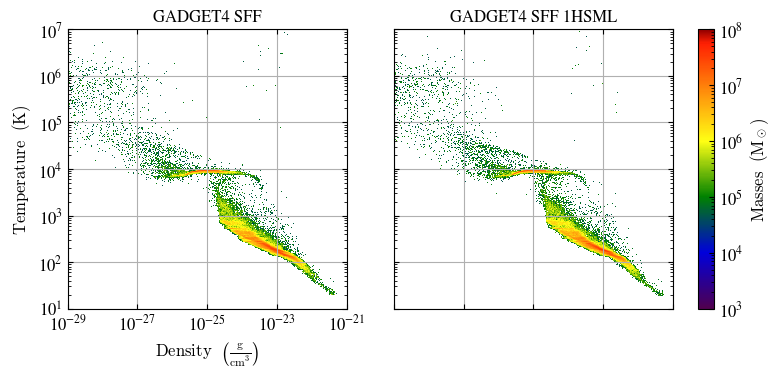

In [355]:
# TEST FIGURES
#ytProjPanel(simsSFF,idxSFF,message="TEST - SFF Density Proj",saveFig=0,showFig=1,verbose=10)
ytPhasePanel(simsSFF,idxSFF,blackLine=0,zFieldLim = (1e3,1e8,1e-29,1e-21,10,1e7),message="TEST - SFF Gas Phase",saveFig=0,showFig=1,verbose=10)


In [ ]:
# DO FULL ANALYSIS - ALL FIGURES

# FIG 1 IC Density Proj
ytProjPanel(sims,[0,0,0,0],message="FIG 1 IC Density Proj")

# FIG 2 NSFF Density Proj
ytProjPanel(simsNSFF,idxNSFF,message="FIG 2 NSFF Density Proj")

# FIG 3 SFF Density Proj
ytProjPanel(simsSFF,idxSFF,message="FIG 3 SFF Density Proj")

# FIG 4 NSFF Surface Density
plotBinned(simsNSFF,idxNSFF,("particle_position_cylindrical_radius","Masses"),50,(1e-3,15),binFunction=binFunctionCilBins,
           setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-1,2*1e3),plotTitle="Cylindrically binned surface density",
           xylabels=("Cylidrincal radius (Kpc)","Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"),message="FIG 4 NSFF Surface Density")

# FIG 5 SFF Surface Density
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","Masses"),50,(1e-3,15),binFunction=binFunctionCilBins,
           setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-1,2*1e3),plotTitle="Cylindrically binned surface density",
           xylabels=("Cylidrincal radius (Kpc)","Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"),message="FIG 5 SFF Surface Density")

# FIG 6 NSFF Vertical Surface Density
plotBinned(simsNSFF,idxNSFF,("z_abs","Masses"),10,(1e-3,1.4),spLim=15,message="FIG 6 NSFF Vertical Surface Density",
           binFunction=binFunctionZBins,setUnits=("kpc","Msun"),xlims=(1e-3,1.4),ylims=(1e-1,3e3),plotTitle="Vertically binned surface density",
           xylabels=("Vertical height (Kpc)","Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"))

# FIG 7 SFF Vertical Surface Density
plotBinned(simsSFF,idxSFF,("z_abs","Masses"),10,(1e-3,1.4),spLim=15,message="FIG 7 SFF Vertical Surface Density",binFunction=binFunctionZBins,
           setUnits=("kpc","Msun"),xlims=(1e-3,1.4),ylims=(1e-1,3e3),plotTitle="Vertically binned surface density",
           xylabels=("Vertical height (Kpc)","Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"))

# FIG 8 NSFF Average Height
plotBinned(simsNSFF,idxNSFF,("particle_position_cylindrical_radius","z_abs"),50,(0,14),message="FIG 8 NSFF Average Height",spLim=15,
           wField=(gasPart,"Masses"),setLogs=(False,False),setUnits=("kpc","kpc"),xlims=(0,14),ylims=(0,0.45),
           plotTitle="Average cylindrical vertical height",xylabels=("Cylidrincal radius (Kpc)","Average vertical height (Kpc)"))

# FIG 9 SFF Average Height
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","z_abs"),50,(0,14),message="FIG 9 SFF Average Height",spLim=15,
           wField=(gasPart,"Masses"),setLogs=(False,False),setUnits=("kpc","kpc"),xlims=(0,14),ylims=(0,0.45),
           plotTitle="Average cylindrical vertical height",xylabels=("Cylidrincal radius (Kpc)","Average vertical height (Kpc)"))

# FIG 10 NSFF Velocity Profile
plotBinned(simsNSFF,idxNSFF,("particle_position_cylindrical_radius","particle_velocity_cylindrical_theta"),50,(0,14),
           message="FIG 10 NSFF Velocity Profile",spLim=15,wField=(gasPart,"Masses"),setLogs=(False,False),setUnits=("kpc","km/s"),
           xlims=(0,14),ylims=(0,250),plotTitle="Velocity profile",xylabels=("Cylidrincal radius (Kpc)","Rotational velocity (km/s)"))

# FIG 11 SFF Velocity Profile
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","particle_velocity_cylindrical_theta"),50,(0,14),
           message="FIG 11 SFF Velocity Profile",spLim=15,wField=(gasPart,"Masses"),setLogs=(False,False),setUnits=("kpc","km/s"),xlims=(0,14),
           ylims=(0,250),plotTitle="Velocity profile",xylabels=("Cylidrincal radius (Kpc)","Rotational velocity (km/s)"))

# FIG 12 NSFF Velocity Dispersion
plotRotDisp(simsNSFF,idxNSFF,50,15,part=gasPart,titlePlot="Velocity dispersion profile",message="FIG 12 NSFF Velocity Dispersion")

# FIG 13 SFF Velocity Dispersion
plotRotDisp(simsSFF,idxSFF,50,15,part=gasPart,titlePlot="Velocity dispersion profile",message="FIG 13 SFF Velocity Dispersion")

# FIG 14 NSFF Temperature Proj
ytProjPanel(simsNSFF,idxNSFF,zField="temperature",wField="density_squared",zFieldUnit="K",zFieldLim=(1e1,1e6),message="FIG 14 NSFF Temperature Proj")

# FIG 15 SFF Temperature Proj
ytProjPanel(simsSFF,idxSFF,zField="temperature",wField="density_squared",zFieldUnit="K",zFieldLim=(1e1,1e6),message="FIG 15 SFF Temperature Proj")

# FIG 16 NSFF Gas Phase
ytPhasePanel(simsNSFF,idx,blackLine=1,zFieldLim = (1e3,1e8,1e-29,1e-21,10,1e7),message="FIG 16 NSFF Gas Phase")

# FIG 17 SFF Gas Phase
ytPhasePanel(simsSFF,idx,blackLine=1,zFieldLim = (1e3,1e8,1e-29,1e-21,10,1e7),message="FIG 17 SFF Gas Phase")

# FIG 18 NSFF Gas Density PDF
plotBinned(simsNSFF,idxNSFF,("Density","Masses"),50,(1e-29,1e-21),message="FIG 18 NSFF Gas Density PDF",spLim=15,setLogs=(True,True),
           setUnits=("g/cm**3","Msun"),xlims=(1e-28,1e-21),ylims=(1e4,1e9),plotTitle="Gas Density PDF",
           xylabels=("$\mathrm{Density\ (g/cm^3)}$","$\mathrm{Mass,}\/\mathrm{d}M\mathrm{/dlog}\/\mathrm{\\rho}\/\mathrm{(M_{\odot})}$"))

# FIG 19 SFF Gas Density PDF
plotBinned(simsSFF,idxSFF,("Density","Masses"),50,(1e-29,1e-21),message="FIG 19 SFF Gas Density PDF",blLine=1.67e-24*10,spLim=15,setLogs=(True,True),
           setUnits=("g/cm**3","Msun"),xlims=(1e-28,1e-21),ylims=(1e4,1e9),plotTitle="Gas Density PDF",
           xylabels=("$\mathrm{Density\ (g/cm^3)}$","$\mathrm{Mass,}\/\mathrm{d}M\mathrm{/dlog}\/\mathrm{\\rho}\/\mathrm{(M_{\odot})}$"))

# FIG 20 Gas Density PDF Change
plotBinned(simsSFF,idxSFF,("Density","Masses"),50,(1e-29,1e-21),message="FIG 20 Gas Density PDF Change",logOverload=(True,False),
           legOverload=["GADGET 3","GADGET 4"],diffSims=(simsNSFF,idxNSFF),blLine=1.67e-24*10,spLim=15,errorLim=(-10,10),
           setLogs=(True,True),setUnits=("g/cm**3","Msun"),xlims=(1e-28,1e-21),ylims=(-7e8,3e8),plotTitle="Gas Density PDF Change",
           xylabels=("$\mathrm{Density\ (g/cm^3)}$","$\mathrm{Mass,}\/\mathrm{d}M\mathrm{/dlog}\/\mathrm{\\rho}\/\mathrm{(M_{\odot})}$"),showError=2)

# FIG 21 Star Density Proj
sffHalos = findHalos(simsSFF,idxSFF,starPart,hopThresh=[4e9,1e4])
ytProjPanel(simsSFF,idxSFF,bSize=400,part="PartType4",zField="particle_mass",zFieldUnit="Msun",zFieldLim=(1e4,1e7),ovHalo=sffHalos,
            message="FIG 21 Star Density Proj")

# FIG 22 Star Surface Density
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","Masses"),50,(0,14),message="FIG 22 Star Surface Density",part=starPart,
           binFunction=binFunctionCilBins,setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-1,2e3),plotTitle="Cylindrically binned stellar surface density",
           xylabels=("Cylidrincal radius (Kpc)","Newly Formed Stars Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"))

# FIG 23 Clump Mass Cumulative
plotClumpMassF(simsSFF,idxSFF,sffHalos,message="FIG 23 Clump Mass Cumulative")

# FIG 24 Star Velocity Profile
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","particle_velocity_cylindrical_theta"),50,(0,14),message="FIG 24 Star Velocity Profile",
           part=starPart,spLim=15,wField=(starPart,"Masses"),setLogs=(False,False),setUnits=("kpc","km/s"),xlims=(0,14),ylims=(0,250),
           plotTitle="Newly Formed Stars Velocity Profile",xylabels=("Cylidrincal radius (Kpc)","Rotational velocity (km/s)"))

# FIG 25 Star Velocity Dispersion
plotRotDisp(simsSFF,idxSFF,50,15,part=starPart,titlePlot="Newly Formed Stars Velocity Dispersion Profile",message="FIG 25 Star Velocity Dispersion")

# FIG 26 Total SFR
plotSFR(simsSFF,idxSFF,message="FIG 26 Total SFR")

# FIG 27 SFR Surface Density
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","particle_mass_young_stars"),50,(1e-3,15),message="FIG 27 SFR Surface Density",
           part=starPart,binFunction=binFunctionCilBinsSFR,setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-4,1e1),plotTitle="SFR Surface Density",
           xylabels=("Cylidrincal radius (Kpc)","$\mathrm{Star\ Formation\ Rate\ Surface\ Density\ (M_{\odot}/yr/kpc^2)}$"))

# FIG 28 KS Cil Binned
plotKScil(simsSFF,idxSFF,message="FIG 28 KS Cil Binned")

# FIG 29 SFF Gas Obs
ytPhasePanel(simsSFF,idxSFF, cM=mColorMap2,zFields = ["x_centered","y_centered","den_low_res"], grid=False,wField=0,
             zFieldUnits=0, zFieldLim = (1e0,1e3,-figWidth/2,figWidth/2,-figWidth/2,figWidth/2),xb=binSize,yb=binSize,
             message="FIG 29 SFF Gas Obs", depositionAlg="cic")

# FIG 30 SFR Obs
ytPhasePanel(simsSFF,idxSFF, cM=mColorMap2,part=starPart,zFields = ["x_centered","y_centered","sfr_den_low_res"], grid=False,wField=0,
             zFieldUnits=0, zFieldLim = (3e-4,3e-1,-figWidth/2,figWidth/2,-figWidth/2,figWidth/2),xb=binSize,yb=binSize,
             message="FIG 30 SFR Obs", depositionAlg="cic")

# FIG 31 KS Mock Obs
plotKSmock(simsSFF,idxSFF,binSize,message="FIG 31 KS Mock Obs")

# FIG 32 Metallicity Proj
ytProjPanel(simsSFF,idxSFF,part="PartType0",zField="Metallicity",wField="density_squared",zFieldUnit="1",takeLog=0,zFieldLim=(0.01,0.04),
            cM=mColorMap,message="FIG 32 Metallicity Proj")

# FIG 33 Metal Gas Phase
ytPhasePanel(simsSFF,idx,blackLine=1,zLog=0,zFields = ["Density","Temperature","Metallicity"],wField="Masses",
             zFieldUnits = ["g/cm**3","K","1"],zFieldLim = (1e-2,4e-2,1e-29,1e-21,10,1e7),message="FIG 33 Metal Gas Phase")

# FIG 34 SFF Elevation Map
ytProjPanel(simsSFF,idxSFF,twoAxis=False,zField="elevation",wField="density",zFieldUnit="kpc",zFieldLim=(-1,1),takeLog=0,
            message="FIG 34 SFF Elevation Map")

# FIG 35 SFF Resolution Map
ytProjPanel(simsSFF,idxSFF,twoAxis=True,zField="resolution",wField="inv_volume_sq",zFieldUnit="pc",zFieldLim=(10,1e3),takeLog=1,
            message="FIG 35 SFF Resolution Map")


FIG 1 IC Density Proj
  Setup complete - Starting fig making for Density
  - Projecting GADGET4 SFF at time 0.0 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 0.0 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF 1HSML
  Showing to screen


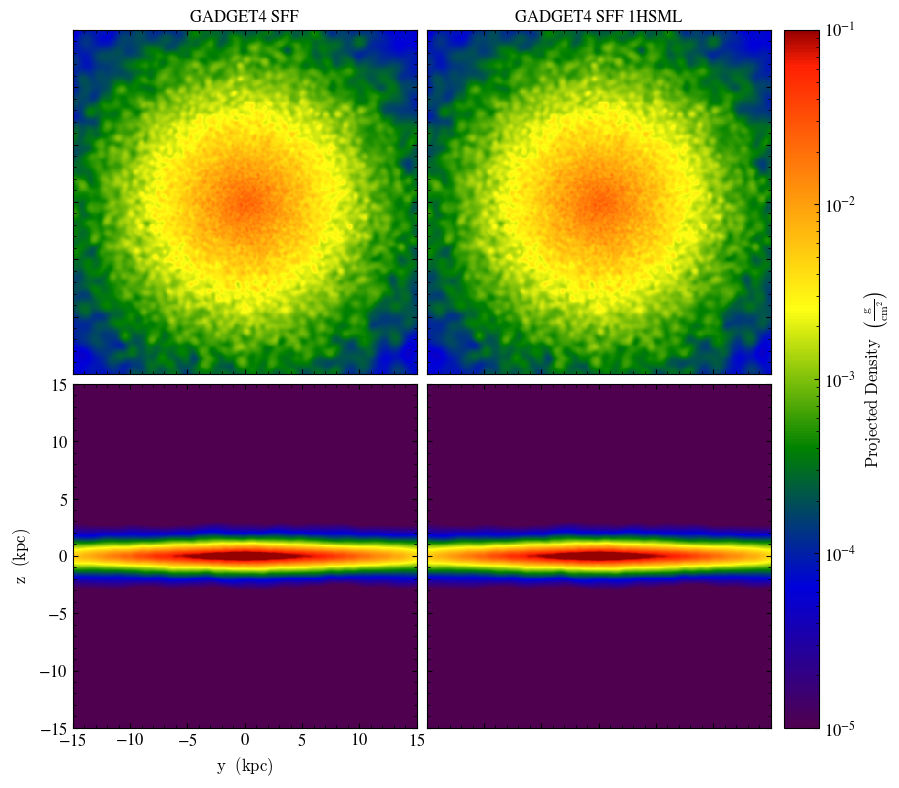

  Saving figure to Figures\fiducial_hsml\FIG_1_IC_Density_Proj.png
FIG 3 SFF Density Proj
  Setup complete - Starting fig making for Density
  - Projecting GADGET4 SFF at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF 1HSML
  Showing to screen


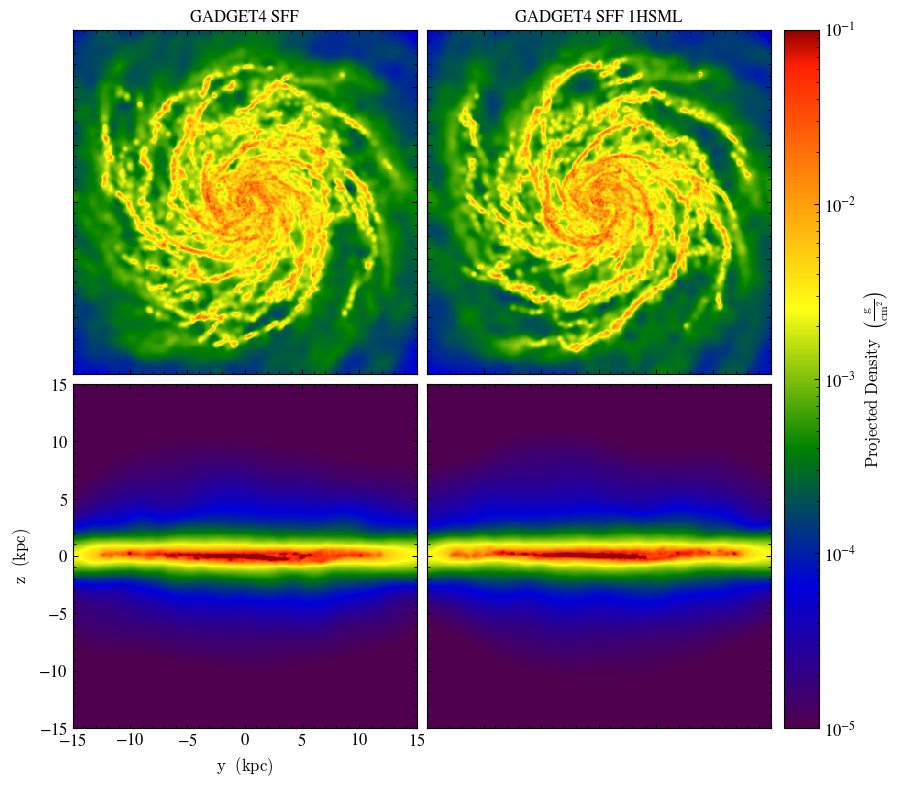

  Saving figure to Figures\fiducial_hsml\FIG_3_SFF_Density_Proj.png
FIG 5 SFF Surface Density
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


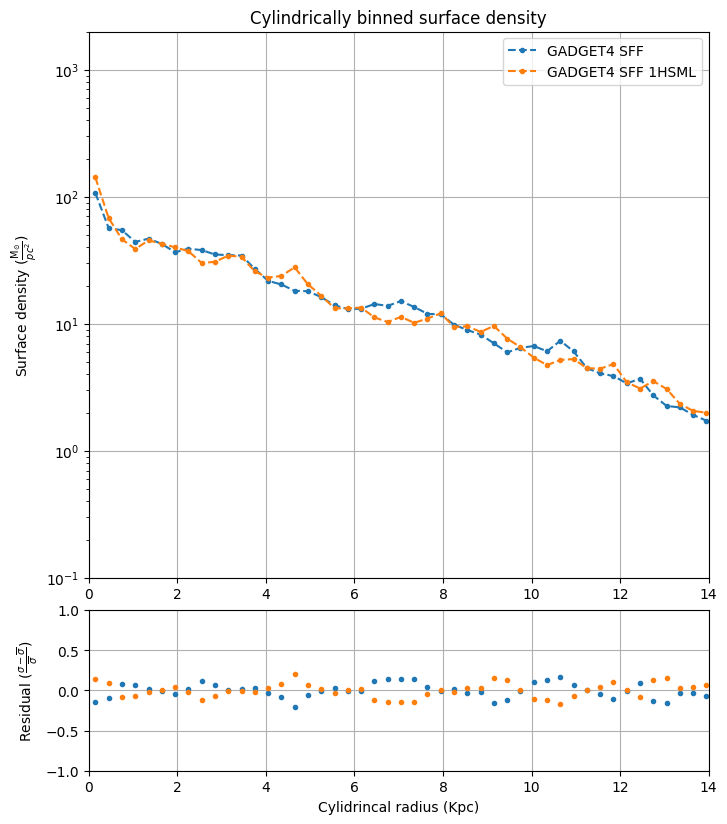

  Saving figure to Figures\fiducial_hsml\FIG_5_SFF_Surface_Density.png
FIG 7 SFF Vertical Surface Density
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


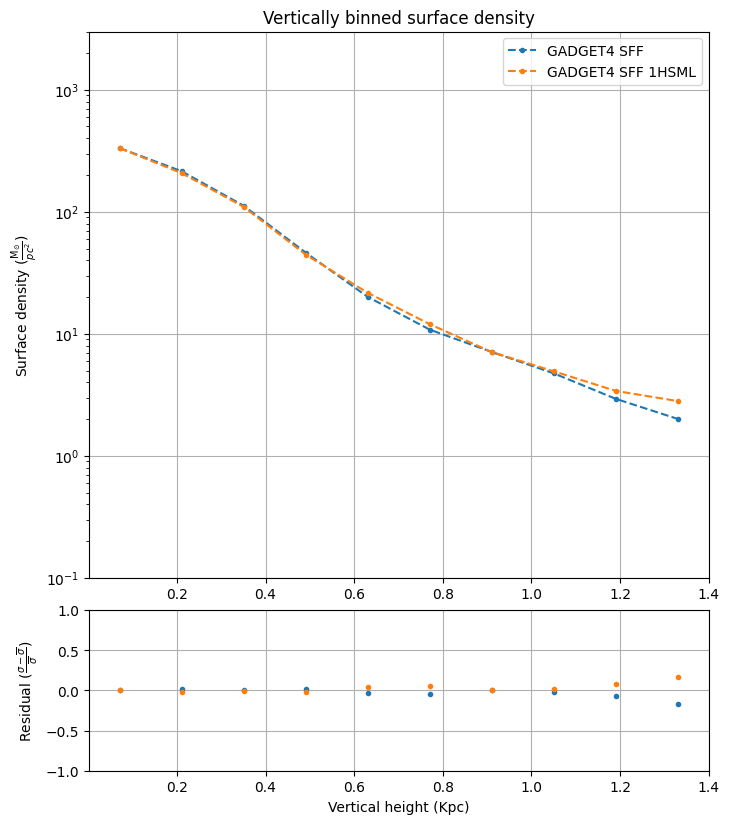

  Saving figure to Figures\fiducial_hsml\FIG_7_SFF_Vertical_Surface_Density.png
FIG 9 SFF Average Height
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


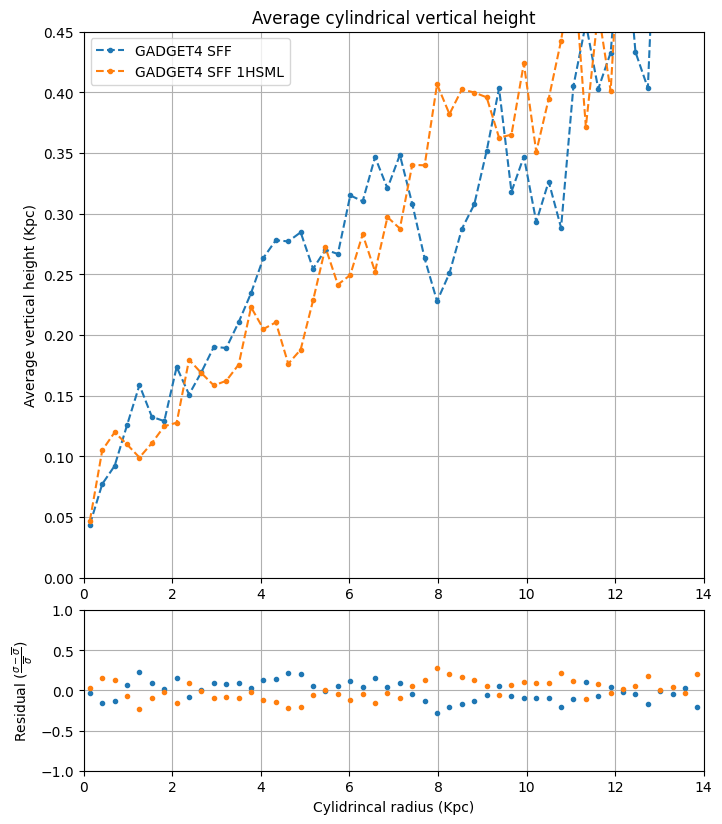

  Saving figure to Figures\fiducial_hsml\FIG_9_SFF_Average_Height.png
FIG 11 SFF Velocity Profile
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


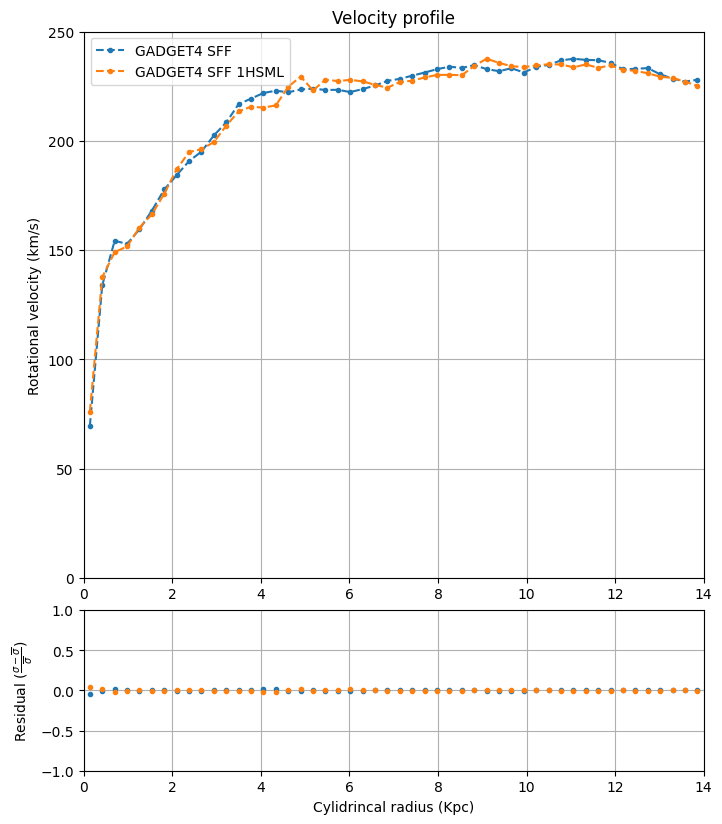

  Saving figure to Figures\fiducial_hsml\FIG_11_SFF_Velocity_Profile.png
FIG 13 SFF Velocity Dispersion
Started GADGET4 SFF
Started GADGET4 SFF 1HSML
  Plotting dispersion
  Plotting dispersion ratio
  Showing to screen


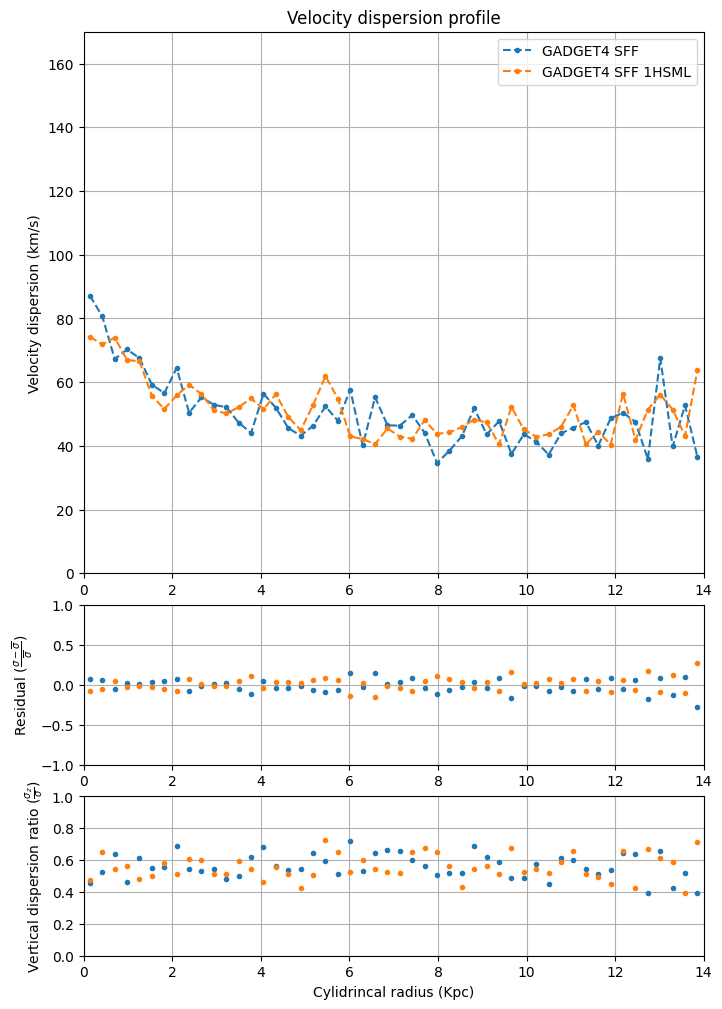

  Saving figure to Figures\fiducial_hsml\FIG_13_SFF_Velocity_Dispersion.png
FIG 15 SFF Temperature Proj
  Setup complete - Starting fig making for temperature
  - Projecting GADGET4 SFF at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF 1HSML
  Showing to screen


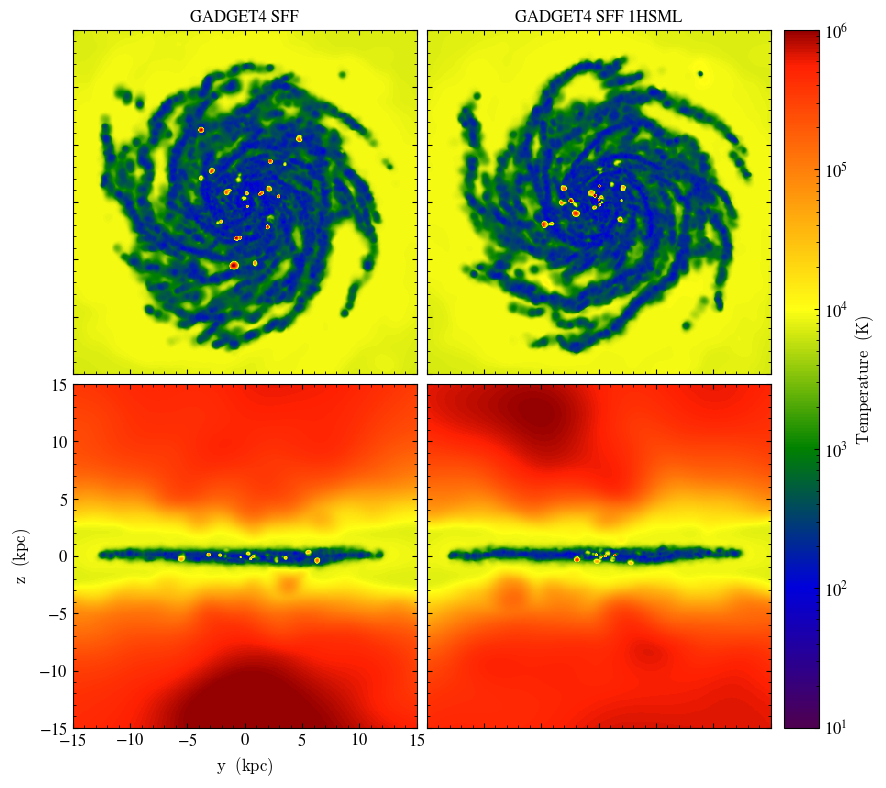

  Saving figure to Figures\fiducial_hsml\FIG_15_SFF_Temperature_Proj.png
FIG 17 SFF Gas Phase
  - Plotting GADGET4 SFF
    Rendering GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML
    Rendering GADGET4 SFF 1HSML
  Showing to screen


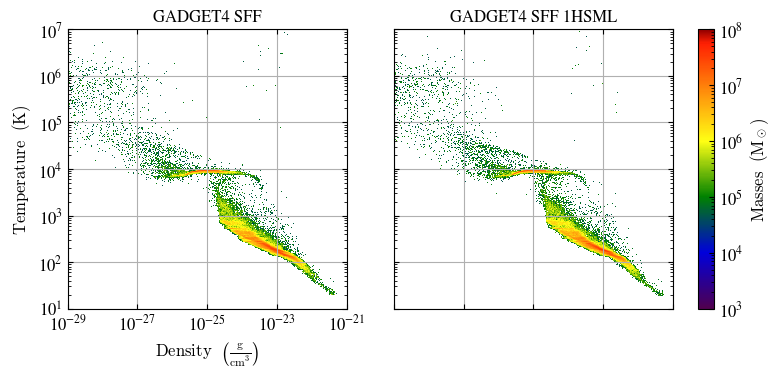

  Saving figure to Figures\fiducial_hsml\FIG_17_SFF_Gas_Phase.png
FIG 19 SFF Gas Density PDF
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


C:\Users\pablo\AppData\Local\Temp\ipykernel_46432\183663347.py:294: RuntimeWarning: invalid value encountered in divide
  error[i] = (allYbin[:,i]-average)/average


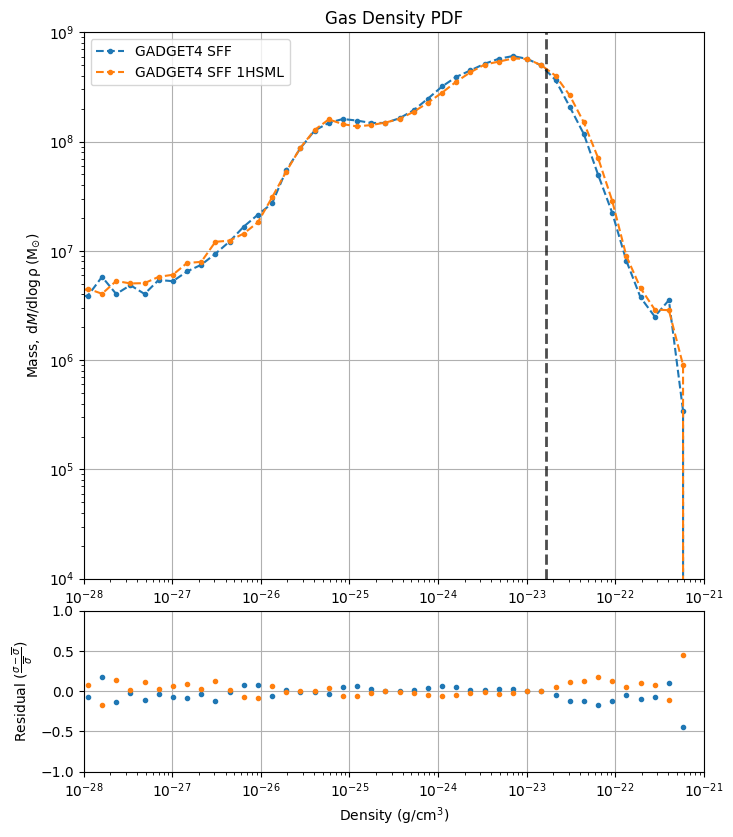

  Saving figure to Figures\fiducial_hsml\FIG_19_SFF_Gas_Density_PDF.png
Initiating halo finding of Type: PartType4 and Method: fof
  - Loading halos for GADGET4 SFF
    Overwriting halos detected in C:\Home\Astro\AGORA\isolated\Halos\Halo_fof_PartType4_GADGET4_SFF\snapshot_050
    Initializing halo finding to be saved in C:\Home\Astro\AGORA\isolated\Halos\Halo_fof_PartType4_GADGET4_SFF\snapshot_050\snapshot_050.0.h5
    Loading halo from file C:\Home\Astro\AGORA\isolated\Halos\Halo_fof_PartType4_GADGET4_SFF\snapshot_050\snapshot_050.0.h5
  - Loading halos for GADGET4 SFF 1HSML
    No halos detected in C:\Home\Astro\AGORA\isolated\Halos\Halo_fof_PartType4_GADGET4_SFF_1HSML\snapshot_050
    Initializing halo finding to be saved in C:\Home\Astro\AGORA\isolated\Halos\Halo_fof_PartType4_GADGET4_SFF_1HSML\snapshot_050\snapshot_050.0.h5
    Loading halo from file C:\Home\Astro\AGORA\isolated\Halos\Halo_fof_PartType4_GADGET4_SFF_1HSML\snapshot_050\snapshot_050.0.h5
  Halo loading successful!
F

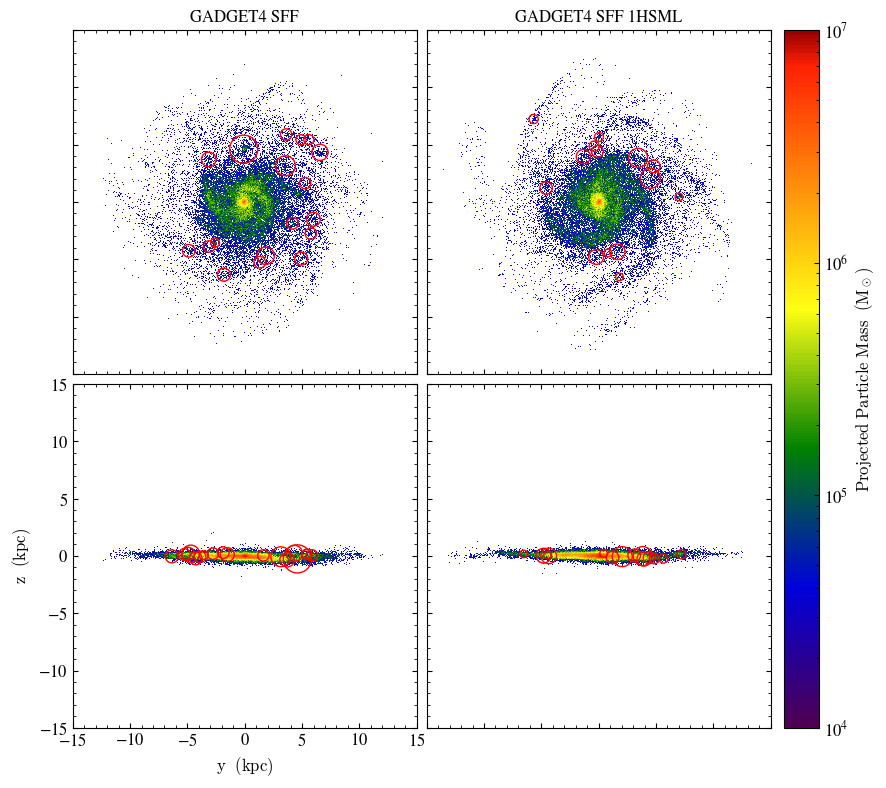

  Saving figure to Figures\fiducial_hsml\FIG_21_Star_Density_Proj.png
FIG 22 Star Surface Density
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


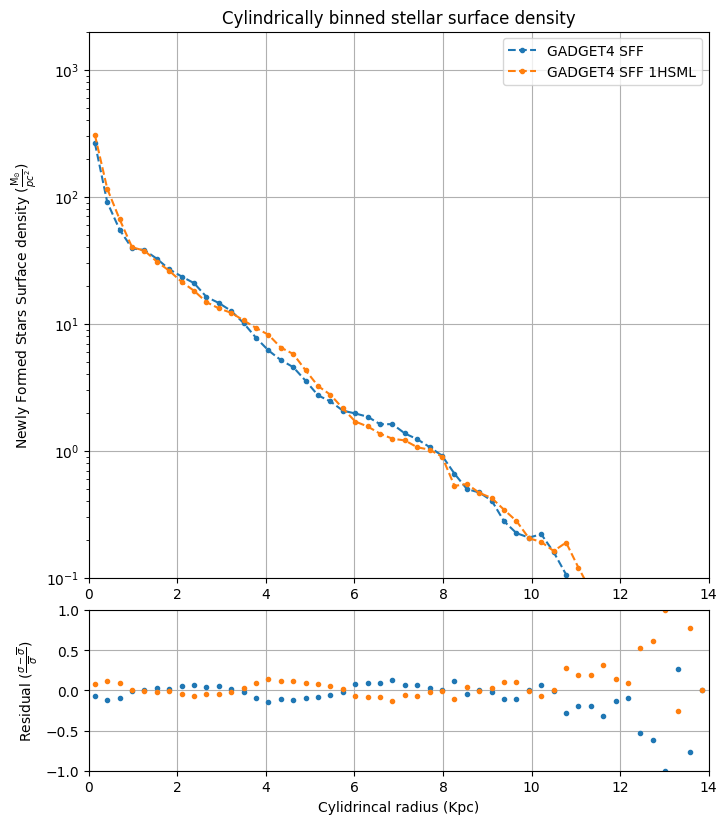

  Saving figure to Figures\fiducial_hsml\FIG_22_Star_Surface_Density.png
FIG 23 Clump Mass Cumulative
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Showing to screen


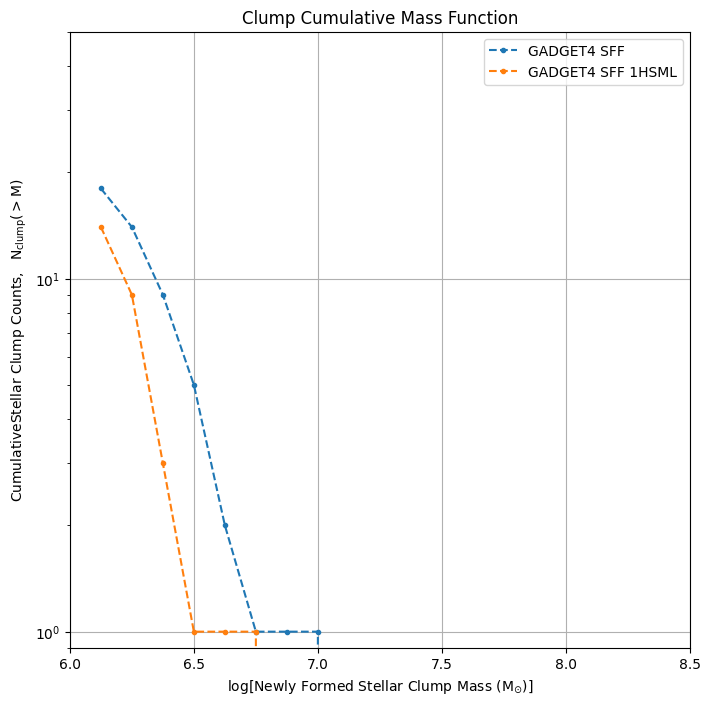

  Saving figure to Figures\fiducial_hsml\FIG_23_Clump_Mass_Cumulative.png
FIG 24 Star Velocity Profile
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


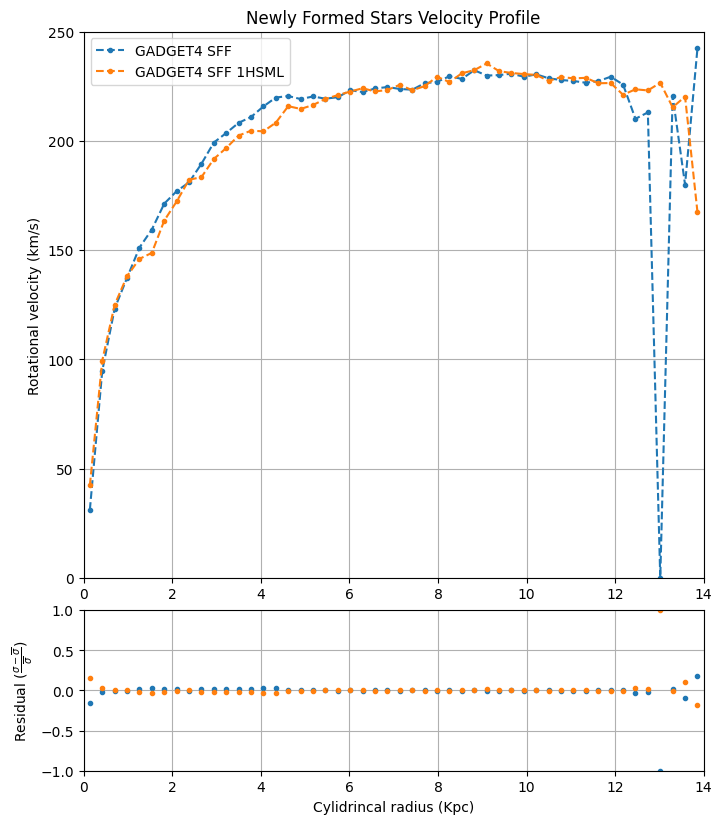

  Saving figure to Figures\fiducial_hsml\FIG_24_Star_Velocity_Profile.png
FIG 25 Star Velocity Dispersion
Started GADGET4 SFF
Started GADGET4 SFF 1HSML
  Plotting dispersion
  Plotting dispersion ratio
  Showing to screen


C:\Users\pablo\AppData\Local\Temp\ipykernel_46432\183663347.py:470: RuntimeWarning: invalid value encountered in divide
  dispRatio = allYbinZ[i,:]/allYbin[i,:]


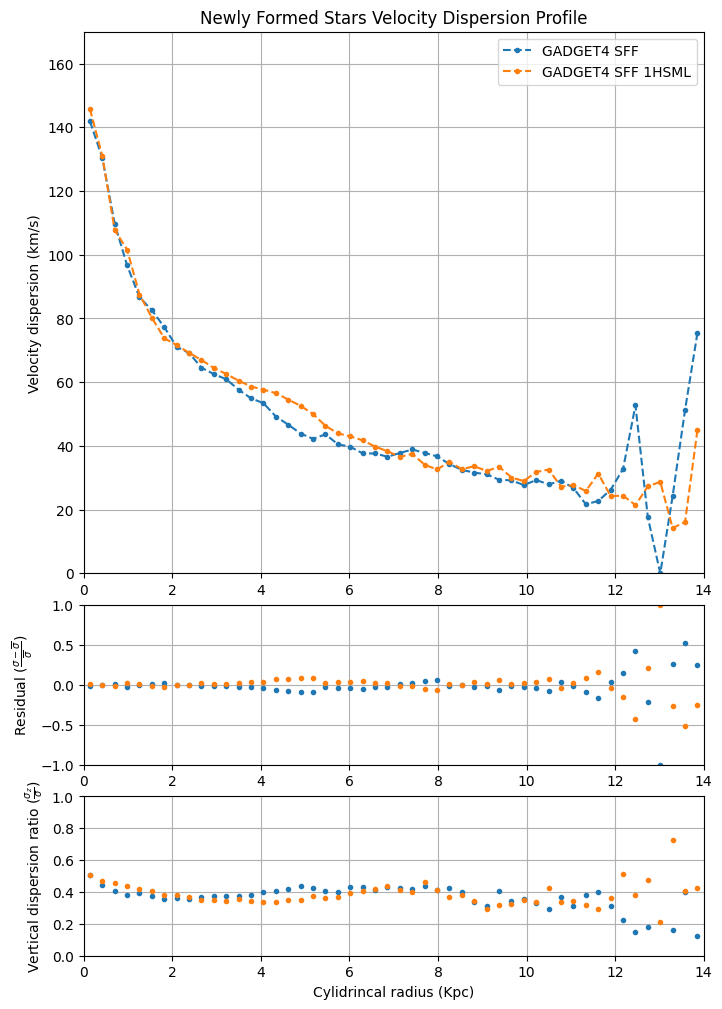

  Saving figure to Figures\fiducial_hsml\FIG_25_Star_Velocity_Dispersion.png
FIG 26 Total SFR
  Started GADGET4 SFF with time 488.89649402996423
     33.00168783867816 %
     66.00337567735632 %
     99.00506351603447 %
  Started GADGET4 SFF 1HSML with time 488.89649402996423
     33.00043047783039 %
     66.00086095566078 %
     99.00129143349118 %
  Showing to screen


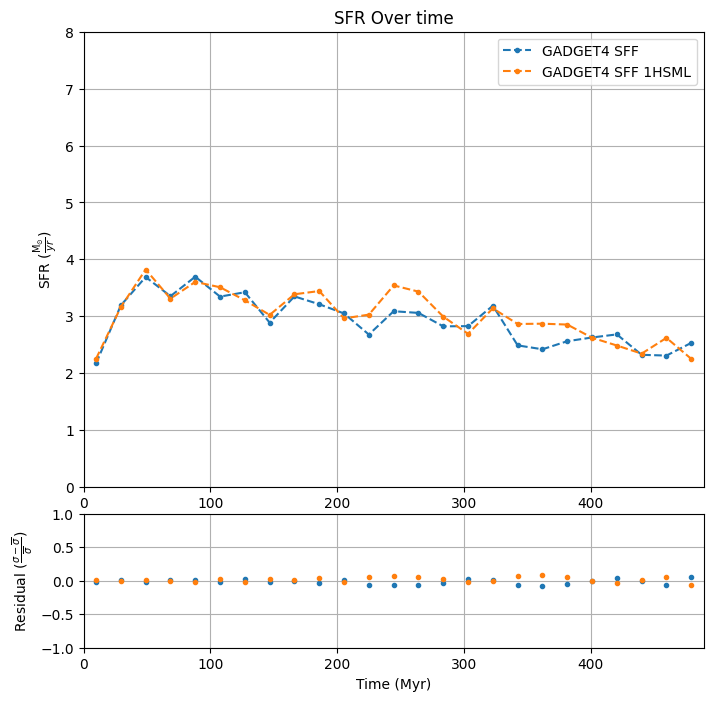

  Saving figure to Figures\fiducial_hsml\FIG_26_Total_SFR.png
FIG 27 SFR Surface Density
  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


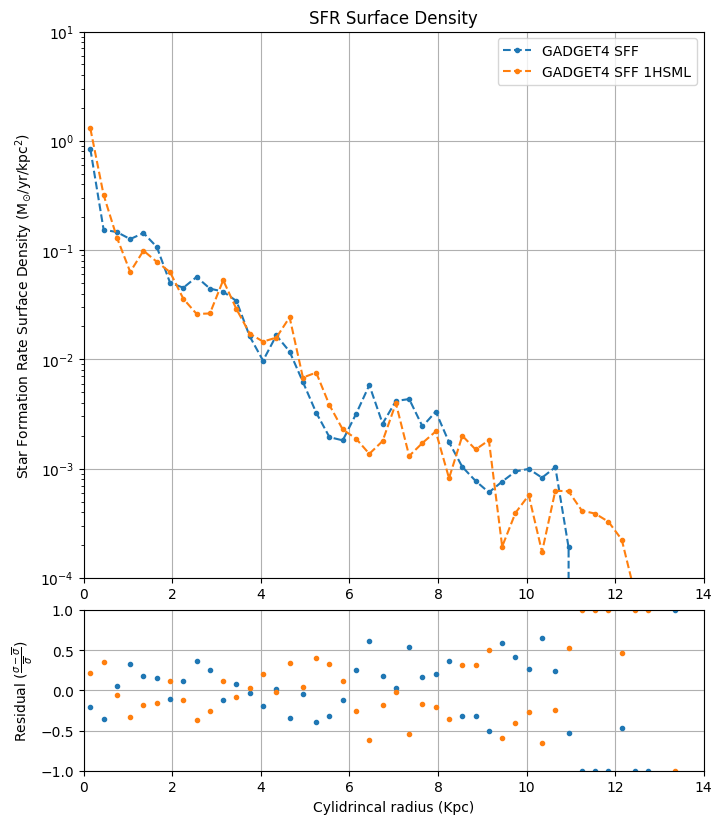

  Saving figure to Figures\fiducial_hsml\FIG_27_SFR_Surface_Density.png
FIG 28 KS Cil Binned
  Started GADGET4 SFF with time 488.89649402996423
  Started GADGET4 SFF 1HSML with time 488.89649402996423
  Showing to screen


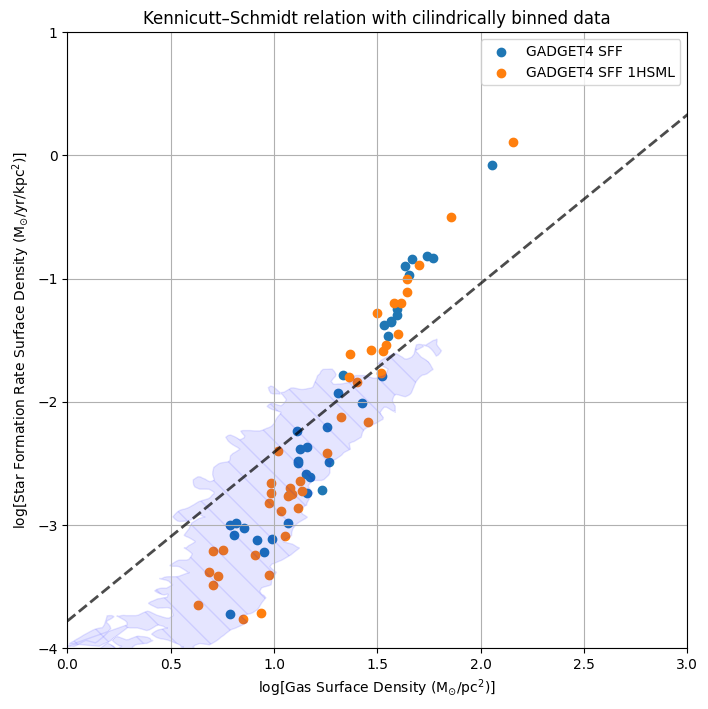

  Saving figure to Figures\fiducial_hsml\FIG_28_KS_Cil_Binned.png
FIG 29 SFF Gas Obs
  - Plotting GADGET4 SFF
    Rendering GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML
    Rendering GADGET4 SFF 1HSML
  Showing to screen


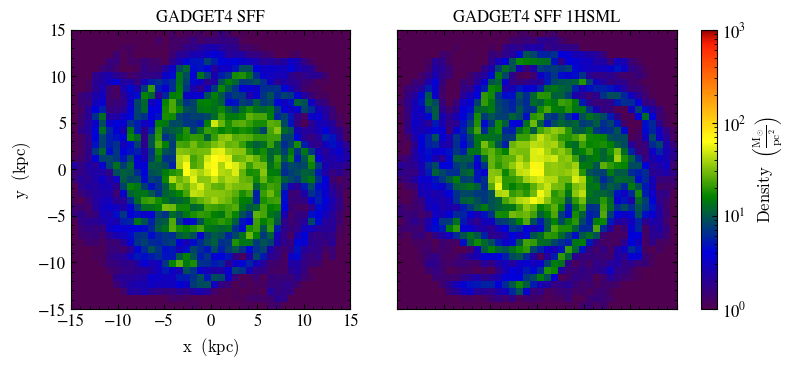

  Saving figure to Figures\fiducial_hsml\FIG_29_SFF_Gas_Obs.png
FIG 30 SFR Obs
  - Plotting GADGET4 SFF
    Rendering GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML
    Rendering GADGET4 SFF 1HSML
  Showing to screen


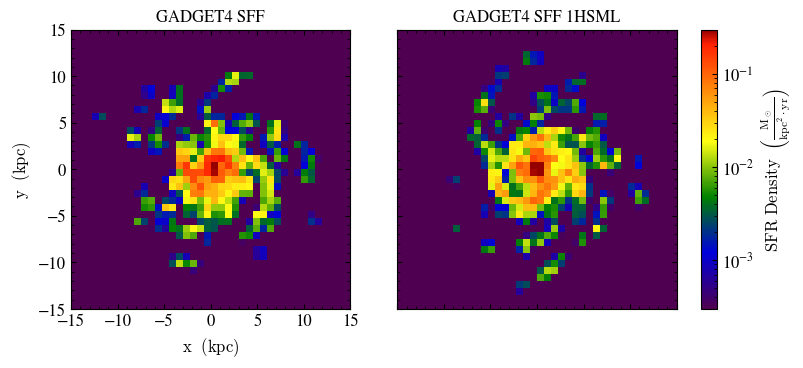

  Saving figure to Figures\fiducial_hsml\FIG_30_SFR_Obs.png
FIG 31 KS Mock Obs
Started GADGET4 SFF
Plotting GADGET4 SFF in z Time 488.89649402996423 Myr


C:\Users\pablo\AppData\Local\Temp\ipykernel_46432\183663347.py:856: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  kernel = kde.gaussian_kde(np.vstack([xKS, yKS]))


Started GADGET4 SFF 1HSML
Plotting GADGET4 SFF 1HSML in z Time 488.89649402996423 Myr
  Showing to screen


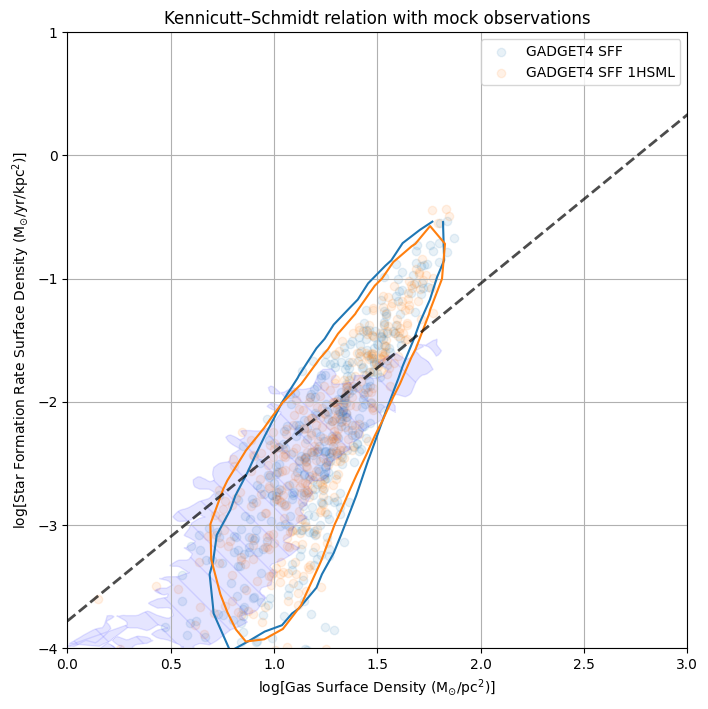

  Saving figure to Figures\fiducial_hsml\FIG_31_KS_Mock_Obs.png
FIG 32 Metallicity Proj
  Setup complete - Starting fig making for Metallicity
  - Projecting GADGET4 SFF at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF 1HSML
  Showing to screen


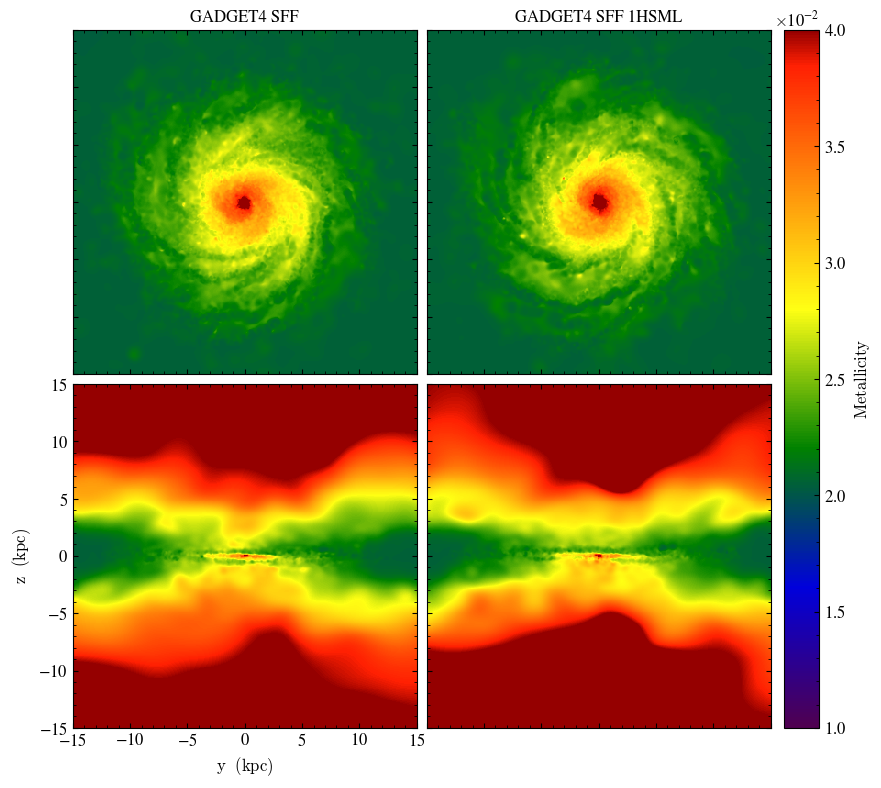

  Saving figure to Figures\fiducial_hsml\FIG_32_Metallicity_Proj.png
FIG 33 Metal Gas Phase
  - Plotting GADGET4 SFF
    Rendering GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML
    Rendering GADGET4 SFF 1HSML
  Showing to screen


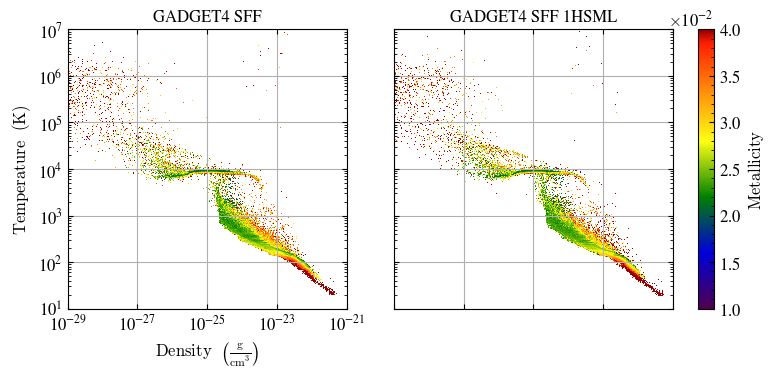

  Saving figure to Figures\fiducial_hsml\FIG_33_Metal_Gas_Phase.png
FIG 34 SFF Elevation Map
  Setup complete - Starting fig making for elevation
  - Projecting GADGET4 SFF at time 488.89649402996423 Myr
    Projecting in axis z
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 488.89649402996423 Myr
    Projecting in axis z
    Rendering GADGET4 SFF 1HSML
  Showing to screen


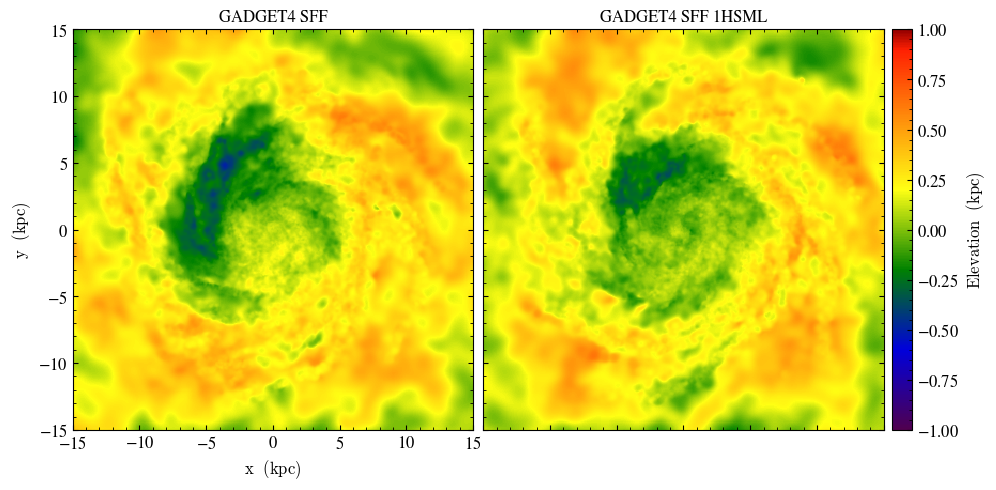

  Saving figure to Figures\fiducial_hsml\FIG_34_SFF_Elevation_Map.png
FIG 35 SFF Resolution Map
  Setup complete - Starting fig making for resolution
  - Projecting GADGET4 SFF at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF 1HSML
  Showing to screen


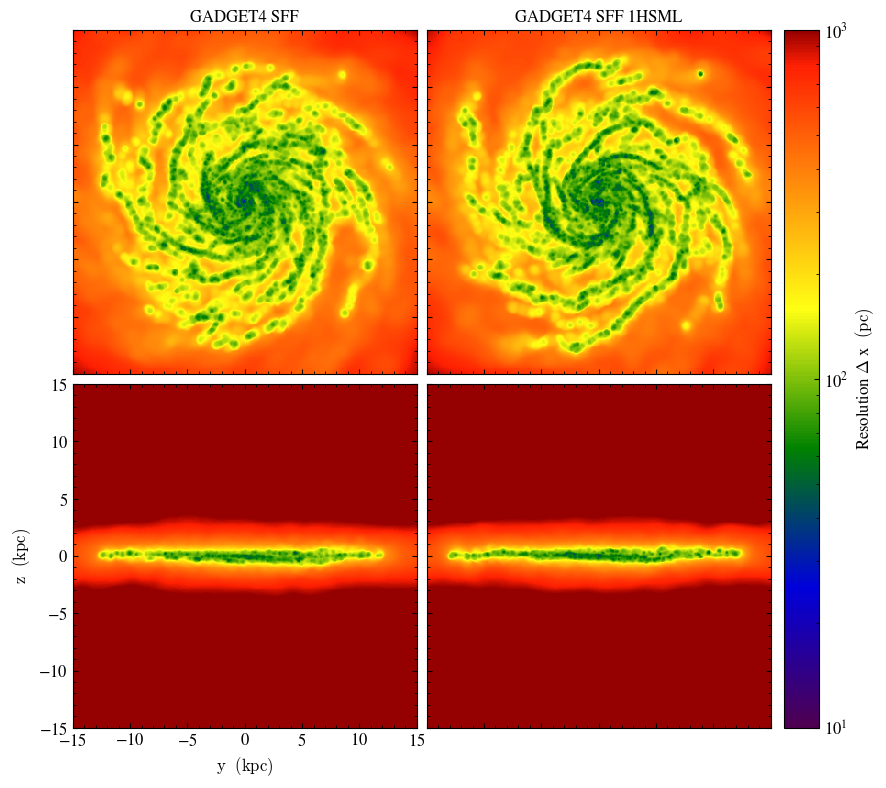

  Saving figure to Figures\fiducial_hsml\FIG_35_SFF_Resolution_Map.png


In [ ]:
# DO ALL ANALYSIS ASSUMMING SIMULATIONS ARE SFF

# FIG 1 IC Density Proj
ytProjPanel(sims,[0,0,0,0],message="FIG 1 IC Density Proj")

# FIG 3 SFF Density Proj
ytProjPanel(simsSFF,idxSFF,message="FIG 3 SFF Density Proj")

# FIG 5 SFF Surface Density
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","Masses"),50,(1e-3,15),binFunction=binFunctionCilBins,
           setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-1,2*1e3),plotTitle="Cylindrically binned surface density",
           xylabels=("Cylidrincal radius (Kpc)","Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"),message="FIG 5 SFF Surface Density")

# FIG 7 SFF Vertical Surface Density
plotBinned(simsSFF,idxSFF,("z_abs","Masses"),10,(1e-3,1.4),spLim=15,message="FIG 7 SFF Vertical Surface Density",binFunction=binFunctionZBins,
           setUnits=("kpc","Msun"),xlims=(1e-3,1.4),ylims=(1e-1,3e3),plotTitle="Vertically binned surface density",
           xylabels=("Vertical height (Kpc)","Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"))

# FIG 9 SFF Average Height
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","z_abs"),50,(0,14),message="FIG 9 SFF Average Height",spLim=15,
           wField=(gasPart,"Masses"),setLogs=(False,False),setUnits=("kpc","kpc"),xlims=(0,14),ylims=(0,0.45),
           plotTitle="Average cylindrical vertical height",xylabels=("Cylidrincal radius (Kpc)","Average vertical height (Kpc)"))

# FIG 11 SFF Velocity Profile
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","particle_velocity_cylindrical_theta"),50,(0,14),
           message="FIG 11 SFF Velocity Profile",spLim=15,wField=(gasPart,"Masses"),setLogs=(False,False),setUnits=("kpc","km/s"),xlims=(0,14),
           ylims=(0,250),plotTitle="Velocity profile",xylabels=("Cylidrincal radius (Kpc)","Rotational velocity (km/s)"))

# FIG 13 SFF Velocity Dispersion
plotRotDisp(simsSFF,idxSFF,50,15,part=gasPart,titlePlot="Velocity dispersion profile",message="FIG 13 SFF Velocity Dispersion")

# FIG 15 SFF Temperature Proj
ytProjPanel(simsSFF,idxSFF,zField="temperature",wField="density_squared",zFieldUnit="K",zFieldLim=(1e1,1e6),message="FIG 15 SFF Temperature Proj")

# FIG 17 SFF Gas Phase
ytPhasePanel(simsSFF,idx,blackLine=0,zFieldLim = (1e3,1e8,1e-29,1e-21,10,1e7),message="FIG 17 SFF Gas Phase")

# FIG 19 SFF Gas Density PDF
plotBinned(simsSFF,idxSFF,("Density","Masses"),50,(1e-29,1e-21),message="FIG 19 SFF Gas Density PDF",blLine=1.67e-24*10,spLim=15,setLogs=(True,True),
           setUnits=("g/cm**3","Msun"),xlims=(1e-28,1e-21),ylims=(1e4,1e9),plotTitle="Gas Density PDF",
           xylabels=("$\mathrm{Density\ (g/cm^3)}$","$\mathrm{Mass,}\/\mathrm{d}M\mathrm{/dlog}\/\mathrm{\\rho}\/\mathrm{(M_{\odot})}$"))

# FIG 21 Star Density Proj
sffHalos = findHalos(simsSFF,idxSFF,starPart,hopThresh=[4e9,1e4])
ytProjPanel(simsSFF,idxSFF,bSize=400,part="PartType4",zField="particle_mass",zFieldUnit="Msun",zFieldLim=(1e4,1e7),ovHalo=sffHalos,
            message="FIG 21 Star Density Proj")

# FIG 22 Star Surface Density
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","Masses"),50,(0,14),message="FIG 22 Star Surface Density",part=starPart,
           binFunction=binFunctionCilBins,setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-1,2e3),plotTitle="Cylindrically binned stellar surface density",
           xylabels=("Cylidrincal radius (Kpc)","Newly Formed Stars Surface density ($\\frac{\mathrm{M}_{\odot}}{pc^2}$)"))

# FIG 23 Clump Mass Cumulative
plotClumpMassF(simsSFF,idxSFF,sffHalos,message="FIG 23 Clump Mass Cumulative")

# FIG 24 Star Velocity Profile
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","particle_velocity_cylindrical_theta"),50,(0,14),message="FIG 24 Star Velocity Profile",
           part=starPart,spLim=15,wField=(starPart,"Masses"),setLogs=(False,False),setUnits=("kpc","km/s"),xlims=(0,14),ylims=(0,250),
           plotTitle="Newly Formed Stars Velocity Profile",xylabels=("Cylidrincal radius (Kpc)","Rotational velocity (km/s)"))

# FIG 25 Star Velocity Dispersion
plotRotDisp(simsSFF,idxSFF,50,15,part=starPart,titlePlot="Newly Formed Stars Velocity Dispersion Profile",message="FIG 25 Star Velocity Dispersion")

# FIG 26 Total SFR
plotSFR(simsSFF,idxSFF,message="FIG 26 Total SFR")

# FIG 27 SFR Surface Density
plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","particle_mass_young_stars"),50,(1e-3,15),message="FIG 27 SFR Surface Density",
           part=starPart,binFunction=binFunctionCilBinsSFR,setUnits=("kpc","Msun"),xlims=(0,14),ylims=(1e-4,1e1),plotTitle="SFR Surface Density",
           xylabels=("Cylidrincal radius (Kpc)","$\mathrm{Star\ Formation\ Rate\ Surface\ Density\ (M_{\odot}/yr/kpc^2)}$"))

# FIG 28 KS Cil Binned
plotKScil(simsSFF,idxSFF,message="FIG 28 KS Cil Binned")

# FIG 29 SFF Gas Obs
ytPhasePanel(simsSFF,idxSFF, cM=mColorMap2,zFields = ["x_centered","y_centered","den_low_res"], grid=False,wField=0,
             zFieldUnits=0, zFieldLim = (1e0,1e3,-figWidth/2,figWidth/2,-figWidth/2,figWidth/2),xb=binSize,yb=binSize,
             message="FIG 29 SFF Gas Obs", depositionAlg="cic")

# FIG 30 SFR Obs
ytPhasePanel(simsSFF,idxSFF, cM=mColorMap2,part=starPart,zFields = ["x_centered","y_centered","sfr_den_low_res"], grid=False,wField=0,
             zFieldUnits=0, zFieldLim = (3e-4,3e-1,-figWidth/2,figWidth/2,-figWidth/2,figWidth/2),xb=binSize,yb=binSize,
             message="FIG 30 SFR Obs", depositionAlg="cic")

# FIG 31 KS Mock Obs
plotKSmock(simsSFF,idxSFF,binSize,message="FIG 31 KS Mock Obs")

# FIG 32 Metallicity Proj
ytProjPanel(simsSFF,idxSFF,part="PartType0",zField="Metallicity",wField="density_squared",zFieldUnit="1",takeLog=0,zFieldLim=(0.01,0.04),
            cM=mColorMap,message="FIG 32 Metallicity Proj")

# FIG 33 Metal Gas Phase
ytPhasePanel(simsSFF,idxSFF,blackLine=0,zLog=0,zFields = ["Density","Temperature","Metallicity"],wField="Masses",
             zFieldUnits = ["g/cm**3","K","1"],zFieldLim = (1e-2,4e-2,1e-29,1e-21,10,1e7),message="FIG 33 Metal Gas Phase")

# FIG 34 SFF Elevation Map
ytProjPanel(simsSFF,idxSFF,twoAxis=False,zField="elevation",wField="density",zFieldUnit="kpc",zFieldLim=(-1,1),takeLog=0,
            message="FIG 34 SFF Elevation Map")

# FIG 35 SFF Resolution Map
ytProjPanel(simsSFF,idxSFF,twoAxis=True,zField="resolution",wField="inv_volume_sq",zFieldUnit="pc",zFieldLim=(10,1e3),takeLog=1,
            message="FIG 35 SFF Resolution Map")


In [ ]:
# EXTRA ANALYSIS (NOT ON PAPER II, BUT OF GREAT INTEREST)

  Setup complete - Starting fig making for SmoothingLength
  - Projecting GADGET4 SFF at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF
  - Projecting GADGET4 SFF 1HSML at time 488.89649402996423 Myr
    Projecting in axis z
    Projecting in axis x
    Rendering GADGET4 SFF 1HSML
  Showing to screen


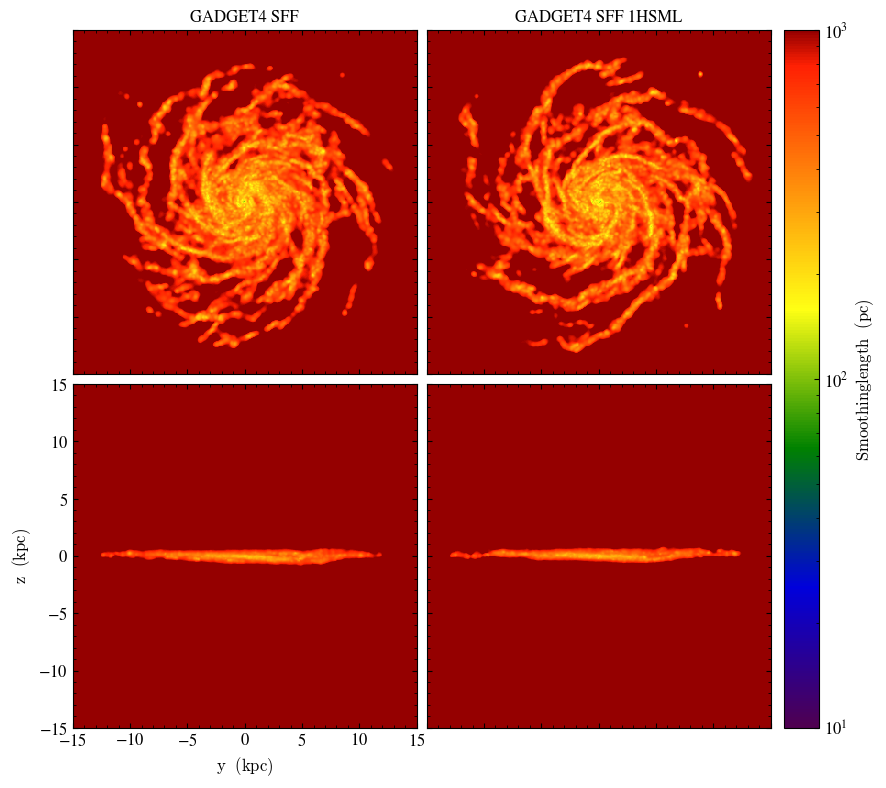

  - Plotting GADGET4 SFF
    Rendering GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML
    Rendering GADGET4 SFF 1HSML
  Showing to screen


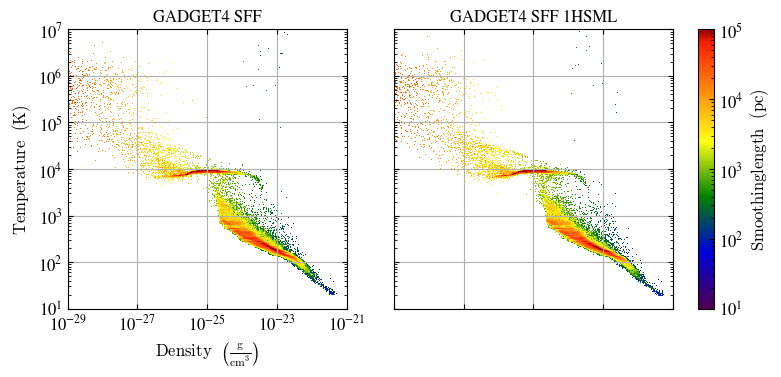

  - Plotting GADGET4 SFF
    Rendering GADGET4 SFF
  - Plotting GADGET4 SFF 1HSML
    Rendering GADGET4 SFF 1HSML
  Showing to screen


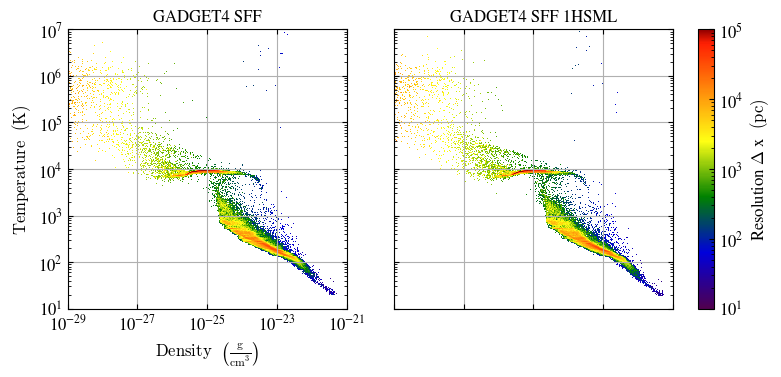

  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


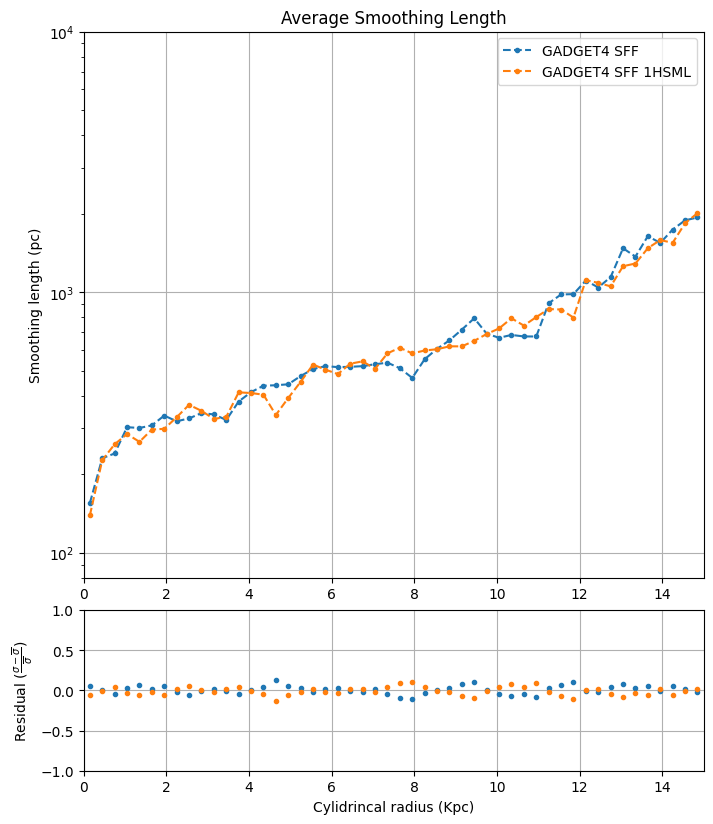

  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


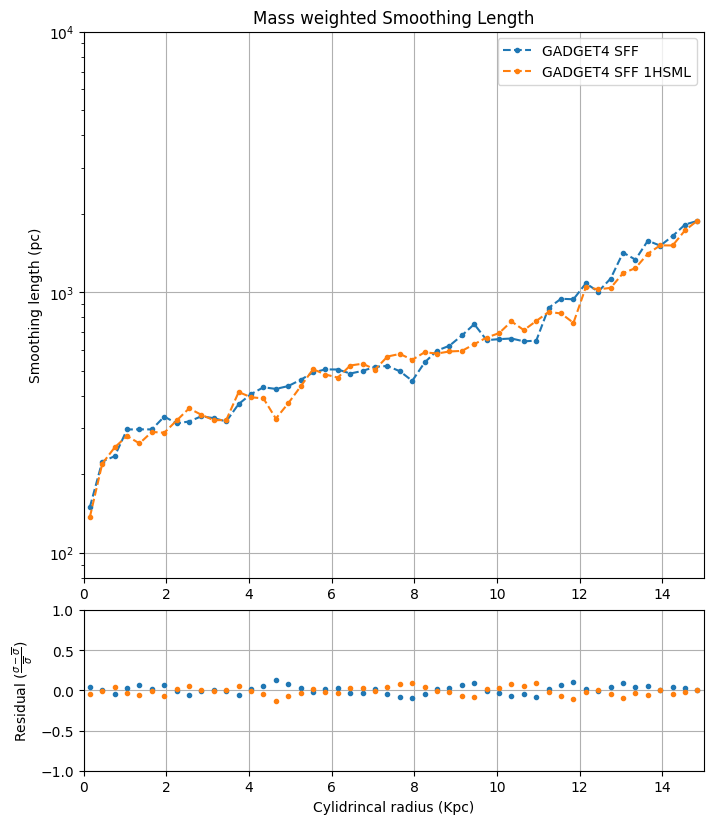

  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


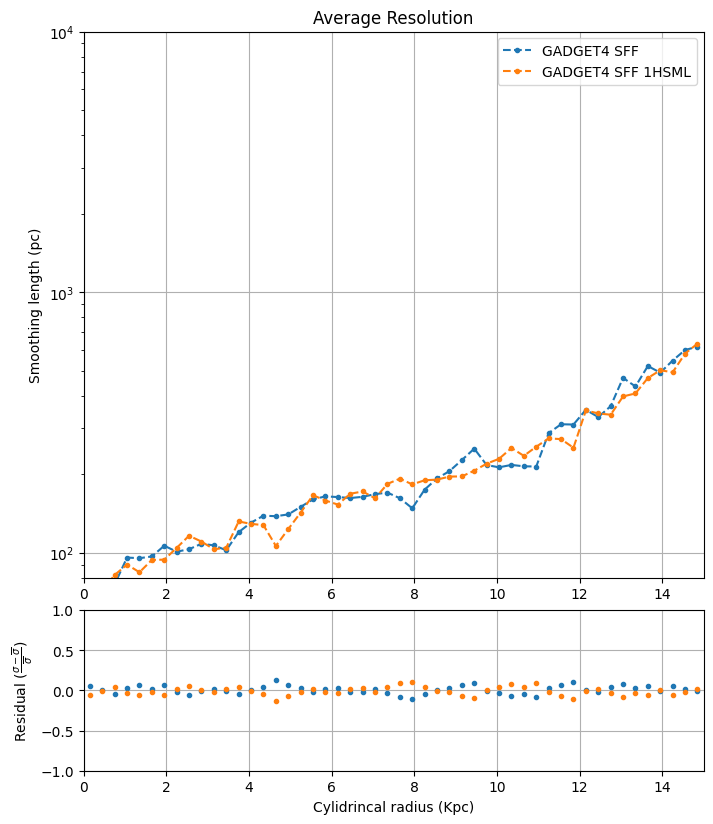

  Started GADGET4 SFF
  Started GADGET4 SFF 1HSML
  Plotting dispersion
  Showing to screen


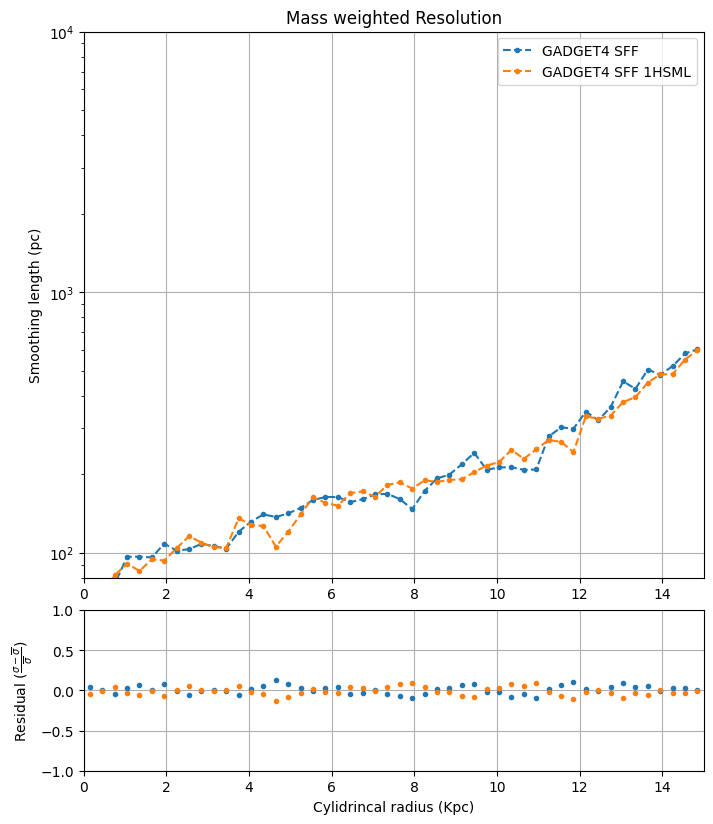

In [370]:
# Smoothing Length

ytProjPanel(simsSFF,idxSFF,twoAxis=True,zField="SmoothingLength",wField="density",zFieldUnit="pc",zFieldLim=(1e1,1e3),takeLog=1, saveFig=0)
 
ytPhasePanel(simsSFF,idxSFF,zLog=1,zFields = ["Density","Temperature","SmoothingLength"],wField=0,
             zFieldUnits = ["g/cm**3","K","pc"],zFieldLim = (1e1,1e5,1e-29,1e-21,10,1e7), saveFig=0)

ytPhasePanel(simsSFF,idxSFF,zLog=1,zFields = ["Density","Temperature","resolution"],wField=0,
             zFieldUnits = ["g/cm**3","K","pc"],zFieldLim = (1e1,1e5,1e-29,1e-21,10,1e7), saveFig=0)

#ytPhasePanel(simsSFF,idxSFF, cM="algae",part=gasPart,zFields = ["x_centered","y_centered","SmoothingLength"], grid=False,wField=0,
#             zFieldUnits=[0,0,"pc"], zFieldLim = (0,0,-figWidth/2,figWidth/2,-figWidth/2,figWidth/2),xb=500,yb=500,
#             depositionAlg="ngp", saveFig=0)

plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","SmoothingLength"),50,(0,15),
           wField=(gasPart,"particle_ones"),setLogs=(False,True),setUnits=("kpc","pc"),xlims=(0,15),
           ylims=(8e1,1e4),plotTitle="Average Smoothing Length",xylabels=("Cylidrincal radius (Kpc)","Smoothing length (pc)"),saveFig=0)

plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","SmoothingLength"),50,(0,15),
           wField=(gasPart,"Masses"),setLogs=(False,True),setUnits=("kpc","pc"),xlims=(0,15),
           ylims=(8e1,1e4),plotTitle="Mass weighted Smoothing Length",xylabels=("Cylidrincal radius (Kpc)","Smoothing length (pc)"),saveFig=0)

plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","resolution"),50,(0,15),
           wField=(gasPart,"particle_ones"),setLogs=(False,True),setUnits=("kpc","pc"),xlims=(0,15),
           ylims=(8e1,1e4),plotTitle="Average Resolution",xylabels=("Cylidrincal radius (Kpc)","Smoothing length (pc)"),saveFig=0)

plotBinned(simsSFF,idxSFF,("particle_position_cylindrical_radius","resolution"),50,(0,15),
           wField=(gasPart,"Masses"),setLogs=(False,True),setUnits=("kpc","pc"),xlims=(0,15),
           ylims=(8e1,1e4),plotTitle="Mass weighted Resolution",xylabels=("Cylidrincal radius (Kpc)","Smoothing length (pc)"),saveFig=0)

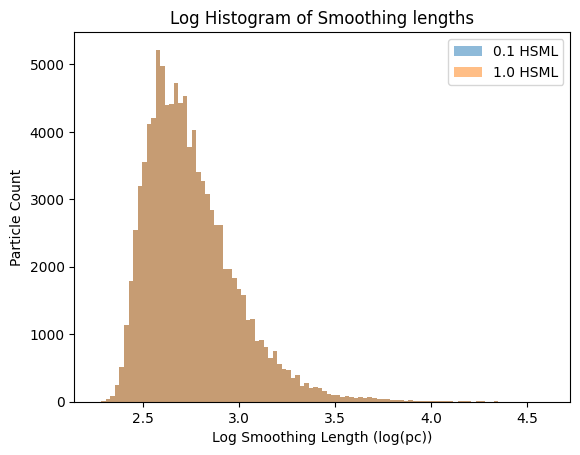

In [388]:
snap1 = ytG4sffHsml[0]
snap2 = ytG4sff[0]
hsml1 = np.array(snap1.r["PartType0","SmoothingLength"].to("pc"))
hsml2 = np.array(snap2.r["PartType0","SmoothingLength"].to("pc"))

plt.hist(np.log10(hsml1),100,alpha=0.5)
plt.hist(np.log10(hsml2),100,alpha=0.5)
plt.title("Log Histogram of Smoothing lengths")
plt.xlabel("Log Smoothing Length (log(pc))")
plt.ylabel("Particle Count")
plt.legend(["0.1 HSML","1.0 HSML"])

In [386]:
snap1 = ytG4sffHsml[1]
snap2 = ytG4sff[1]
hsml1 = np.array(snap1.r["PartType0","resolution"])
hsml2 = np.array(snap2.r["PartType0","resolution"])

plt.hist(np.log10(hsml1),100,alpha=0.3)
plt.hist(np.log10(hsml2),100,alpha=0.3)
plt.title("Log Histogram of Resolution")
plt.xlabel("Log Resolution (log(pc))")
plt.ylabel("Particle Count")
plt.legend(["0.1 HSML","1.0 HSML"])

YTDimensionalityError: Dimensionality specified was 2 but we need 3

Started GADGET3 nSFF
Started GADGET4 nSFF


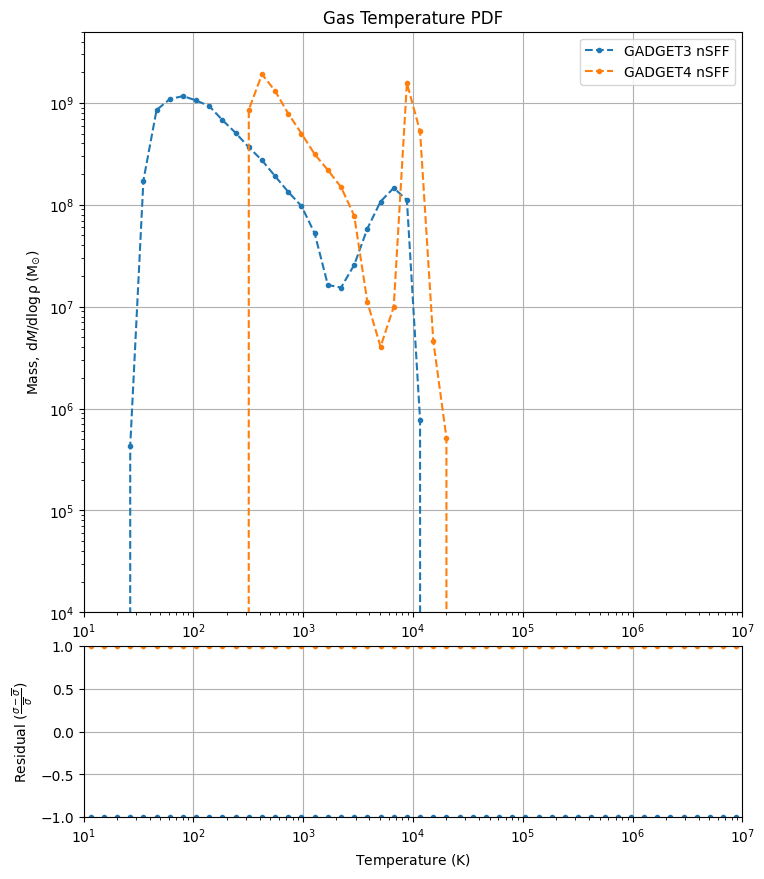

Started GADGET3 SFF
Started GADGET4 SFF


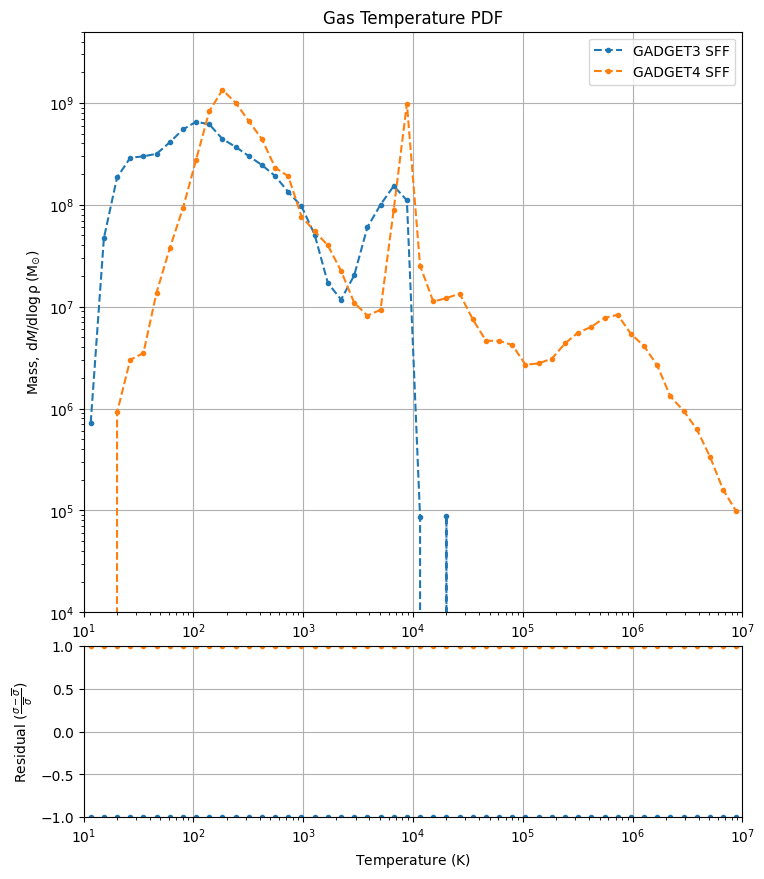

In [98]:
# (Temperature PDFs)

nBins   = 50
rLim    = 0.5*figWidth
figSize = 8.5

def plotTempPDF(sims,idx,nBins,rLim,thresh=0):
    uFig = plt.figure(figsize=(figSize, figSize*1.2))
    uAx  = plt.subplot2grid((4,1),(0,0),rowspan=3)
    uAx2 = plt.subplot2grid((4,1),(3,0),rowspan=1)

    allYbin = [None]*len(sims)
    XGlobal = None
    for k,sn in enumerate(sims):
        print("Started",sn.name)
        sp = sims[k].ytFull[idx[k]].sphere(sims[k].snap[idx[k]].center/1e3,(rLim,"kpc"))
        
        p1 = yt.ProfilePlot(sp,(gasPart,"Temperature"),(gasPart,"Masses"), weight_field=None, n_bins=nBins, x_log=True, accumulation=False)
        p1.set_log((gasPart,"Masses"),True)
        p1.set_log((gasPart,"Temperature"),True)
        p1.set_unit((gasPart,"Masses"), 'Msun')
        p1.set_unit((gasPart,"Temperature"), 'K')
        p1.set_xlim(1e1, 1e7)

        cil = p1.profiles[0].x.in_units('K').d
        bins = p1.profiles[0]["Masses"].in_units('Msun').d
        allYbin[k] = bins
        XGlobal = cil
        uAx.semilogy(cil,bins,".--")
        uAx.semilogx()
    
    allYbin = np.array(allYbin)
    error = [None]*nBins
    for i in range(nBins):
        average = np.mean(allYbin[:,i])
        error[i] = [-1,1]
        #error[i] = (allYbin[:,i]-average)/average
    error = np.array(error)
    for i in range(len(sims)):
        uAx2.semilogx(XGlobal,error[:,i],".")
    uAx2.set_xlim(1e1,1e7)
    uAx2.set_ylim(-1,1)
    uAx2.set_ylabel("Residual ($\\frac{\sigma - \overline{\sigma}}{\overline{\sigma}}$)")
    uAx2.grid()
    uAx2.set_xlabel("$\mathrm{Temperature\ (K)}$")
    
    uAx.set_xlim(1e1,1e7)
    uAx.set_ylim(1e4,5e9)
    
    uAx.set_ylabel("$\mathrm{Mass,}\/\mathrm{d}M\mathrm{/dlog}\/\mathrm{\\rho}\/\mathrm{(M_{\odot})}$")
    uAx.set_title("Gas Temperature PDF")
    uAx.grid()
    uAx.legend([sims[i].name for i in range(len(sims))])
    plt.show()

# NSFF
plotTempPDF(simsNSFF,idxNSFF,nBins,rLim)

# SFF
plotTempPDF(simsSFF,idxSFF,nBins,rLim)

Text(0.5, 0, 'Log of Mass (log(Msun))')

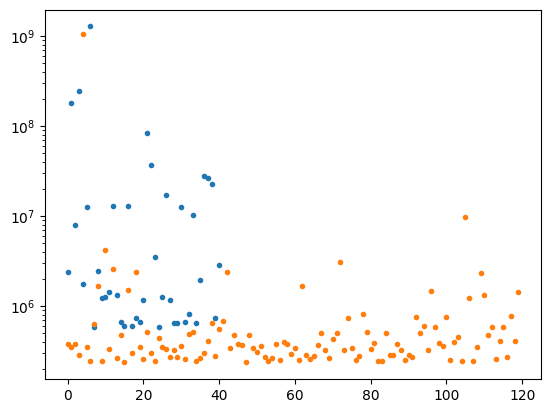

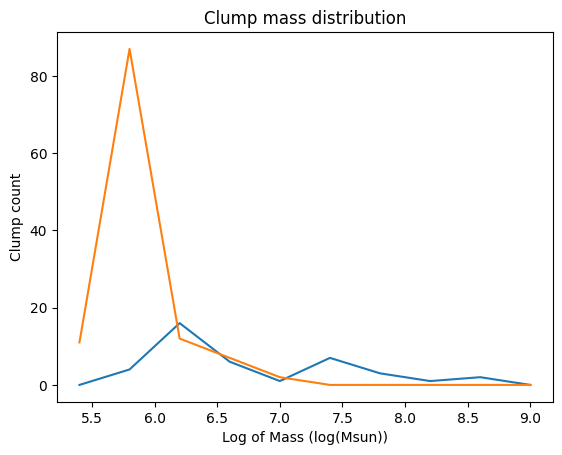

In [254]:
# CLUMP PLOTS

# CLUMP MASS DISTRIBUTION
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for i in range(len(clumpSims)):
    clumpMass = clumpSims[i]['particle_mass'][:].in_units("Msun")
    ax1.semilogy(clumpMass,".")

    clumpLogMass = np.log10(clumpMass)
    hist = np.histogram(clumpLogMass, bins=nBins, range=(mLim[0],mLim[1]))
    dBin = hist[1][1]-hist[1][0]
    ax2.plot(hist[1][:-1]+dBin, hist[0])

ax2.set_title("Clump mass distribution")
ax2.set_ylabel("Clump count")
ax2.set_xlabel("Log of Mass (log(Msun))")


In [ ]:
# FIG 23 (Clump mass function) (Use clump finder first) BUT WITH A LOT MORE LINES OF THE SAME COLOR, EACH WITH DIFF HALOFINDER PARAMETERS FOR THE SAME SIMULATION

nBins = 10
mLim  = (6, 8.5)
figSize = 8

def plotClumpMassF(sims,idx,nBins,rLim):
    uFig = plt.figure(figsize=(figSize, figSize))
    uAx  = plt.subplot2grid((4,1),(0,0),rowspan=4)

    for k,sn in enumerate(sims):
        print("Started",sn.name)
        clumpMass = clumpSims[k]['particle_mass'][clumpFilt[k]].in_units("Msun")

        clumpLogMass = np.log10(clumpMass)
        hist = np.histogram(clumpLogMass, bins=nBins, range=(mLim[0],mLim[1]))
        dBin = hist[1][1]-hist[1][0]
        
        uAx.plot(hist[1][:-1]+dBin, np.cumsum(hist[0][::-1])[::-1],".--")
        uAx.semilogy()
    
    uAx.set_xlim(mLim[0],mLim[1])
    uAx.set_ylim(0.9,50)
    uAx.set_xlabel("$\mathrm{log[Newly\ Formed\ Stellar\ Clump\ Mass\ (M_{\odot})]}$")
    uAx.set_ylabel("$\mathrm{Stellar\ Clump\ Counts, \ \ N_{clump}(M)}$")
    uAx.set_title("Clump Cumulative Mass Function")
    uAx.grid()
    uAx.legend([sims[i].name for i in range(len(sims))])
    plt.show()

# FIG 23
plotClumpMassF(simsSFF,idxSFF,nBins,rLim)


In [39]:
print(ytG4sff[1].field_list)

yt : [WARNING  ] 2025-02-27 20:34:43,838 A bounding box was explicitly specified, so we are disabling periodicity.


[('PartType0', 'CELibCalcium'), ('PartType0', 'CELibCarbon'), ('PartType0', 'CELibHelium'), ('PartType0', 'CELibHydrogen'), ('PartType0', 'CELibIron'), ('PartType0', 'CELibMagnesium'), ('PartType0', 'CELibNeon'), ('PartType0', 'CELibNickel'), ('PartType0', 'CELibNitrogen'), ('PartType0', 'CELibOxygen'), ('PartType0', 'CELibSilicon'), ('PartType0', 'CELibSulfur'), ('PartType0', 'Coordinates'), ('PartType0', 'DI'), ('PartType0', 'DII'), ('PartType0', 'Density'), ('PartType0', 'DustBin0'), ('PartType0', 'DustBin1'), ('PartType0', 'DustBin10'), ('PartType0', 'DustBin11'), ('PartType0', 'DustBin12'), ('PartType0', 'DustBin13'), ('PartType0', 'DustBin14'), ('PartType0', 'DustBin15'), ('PartType0', 'DustBin16'), ('PartType0', 'DustBin17'), ('PartType0', 'DustBin18'), ('PartType0', 'DustBin19'), ('PartType0', 'DustBin2'), ('PartType0', 'DustBin20'), ('PartType0', 'DustBin21'), ('PartType0', 'DustBin22'), ('PartType0', 'DustBin23'), ('PartType0', 'DustBin24'), ('PartType0', 'DustBin25'), ('Part

Setup complete - Starting fig making for HI
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


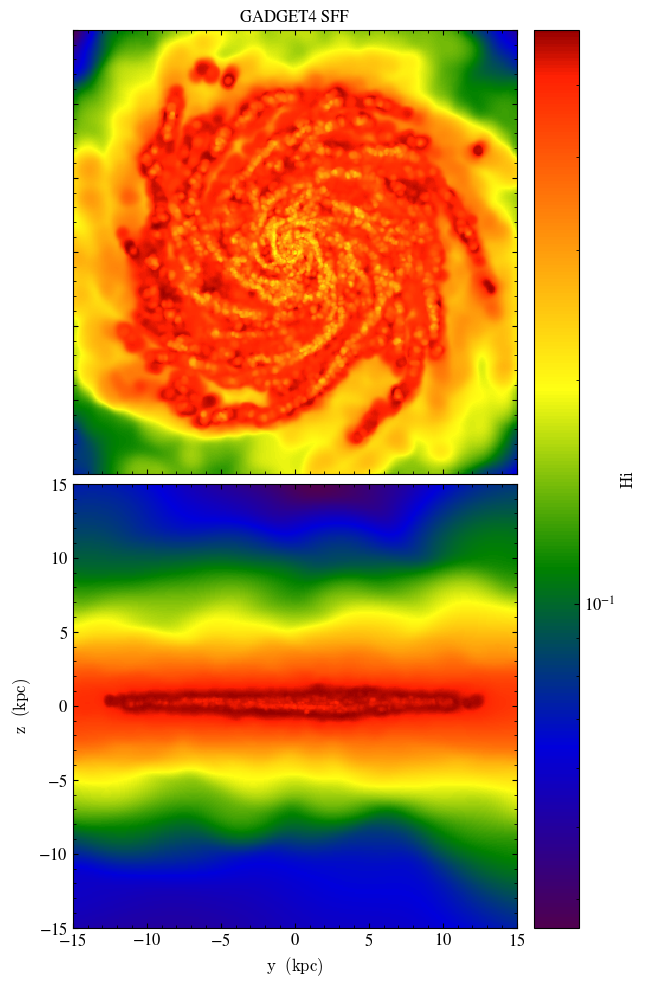

Setup complete - Starting fig making for HII
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


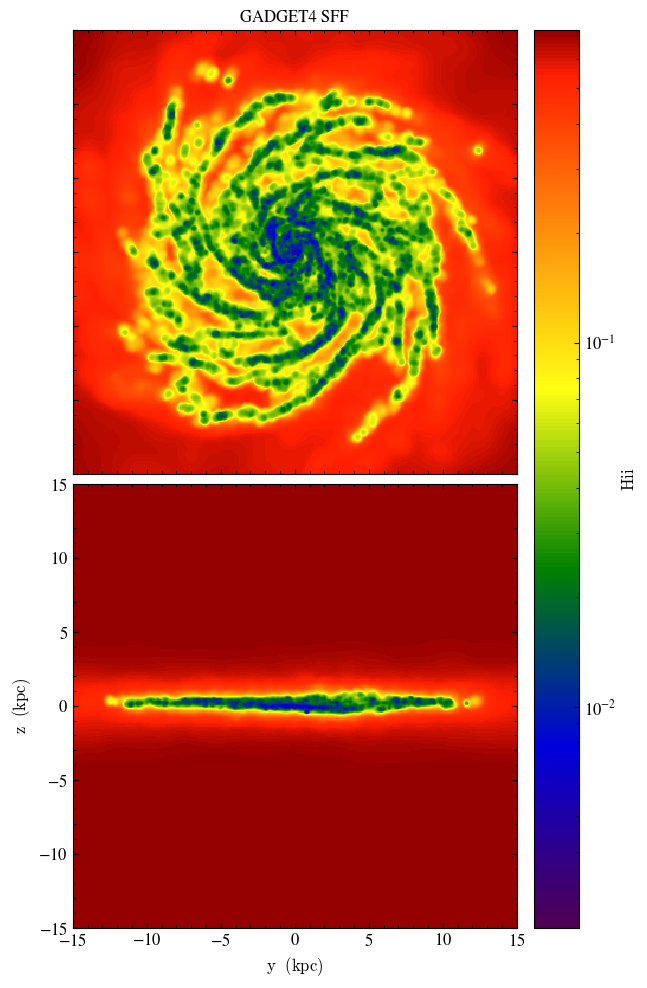

Setup complete - Starting fig making for H2I
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


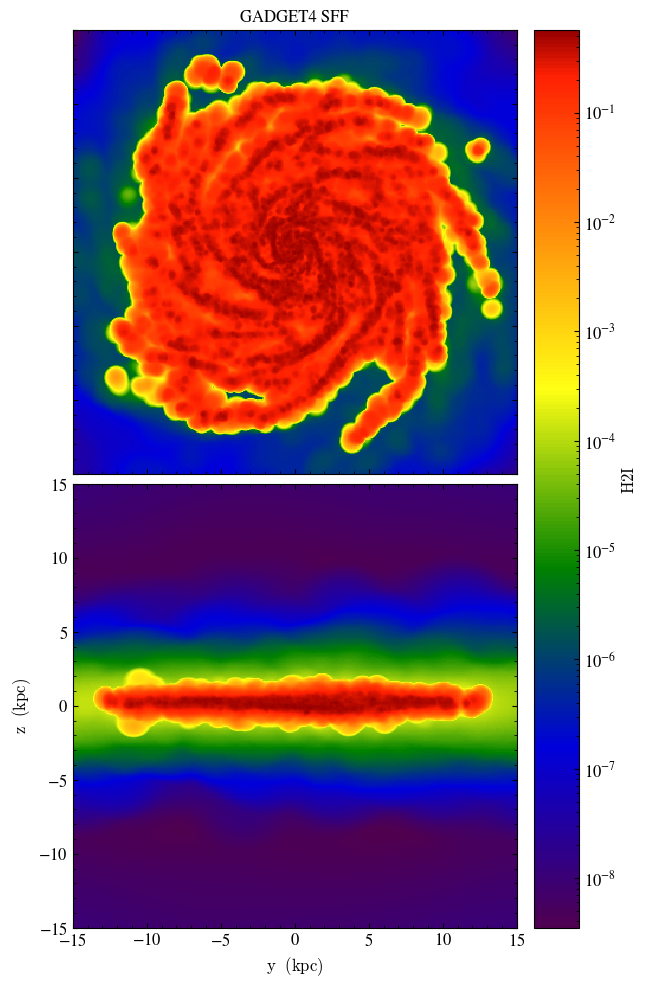

Setup complete - Starting fig making for H2II
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


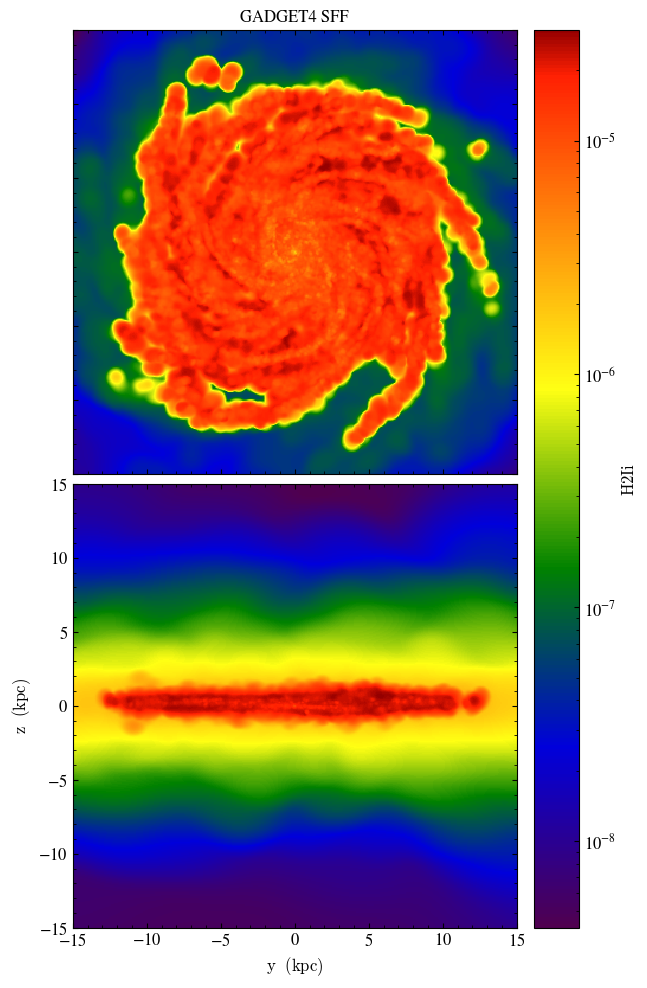

Setup complete - Starting fig making for HDI
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


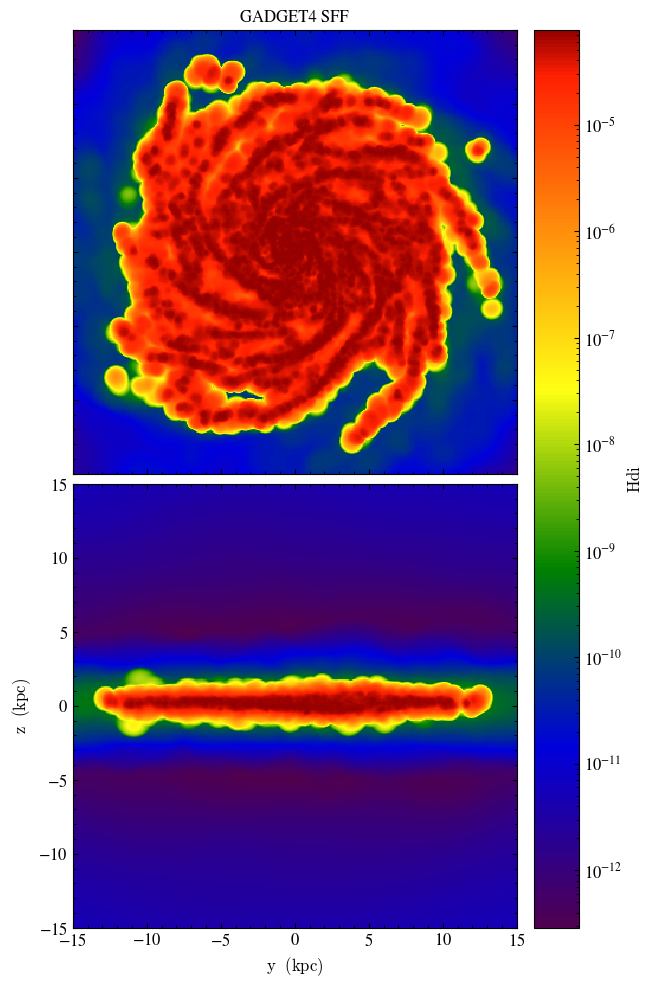

Setup complete - Starting fig making for HM
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


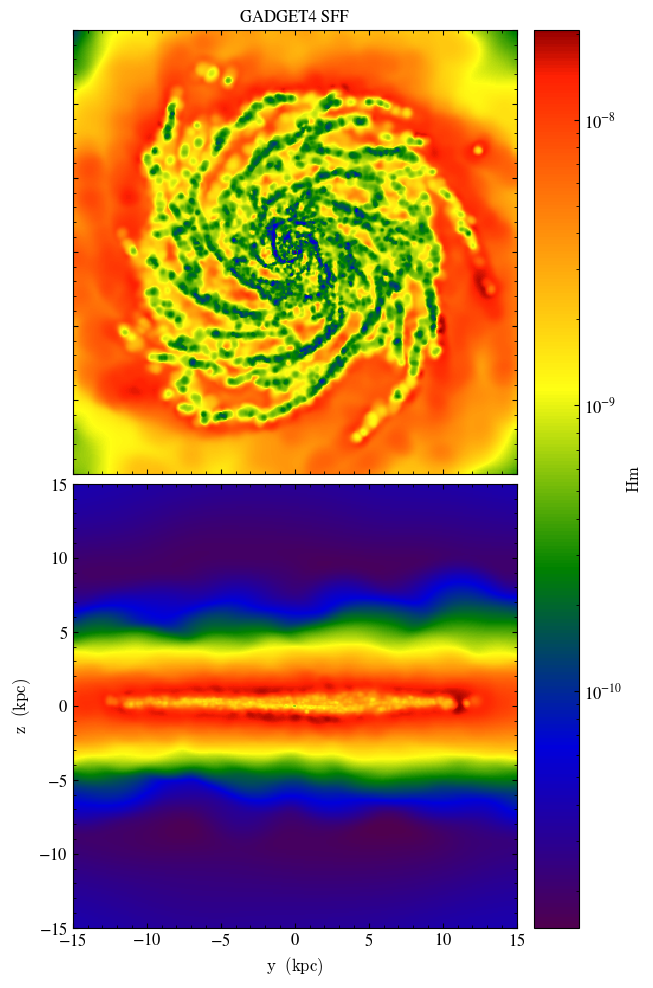

Setup complete - Starting fig making for HeI
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


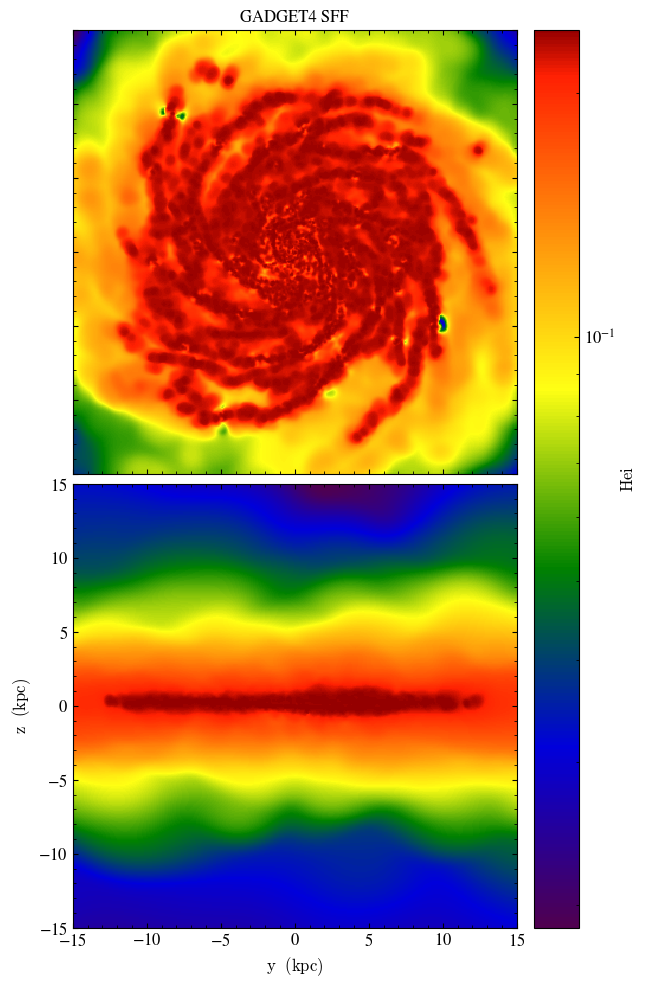

Setup complete - Starting fig making for HeII
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


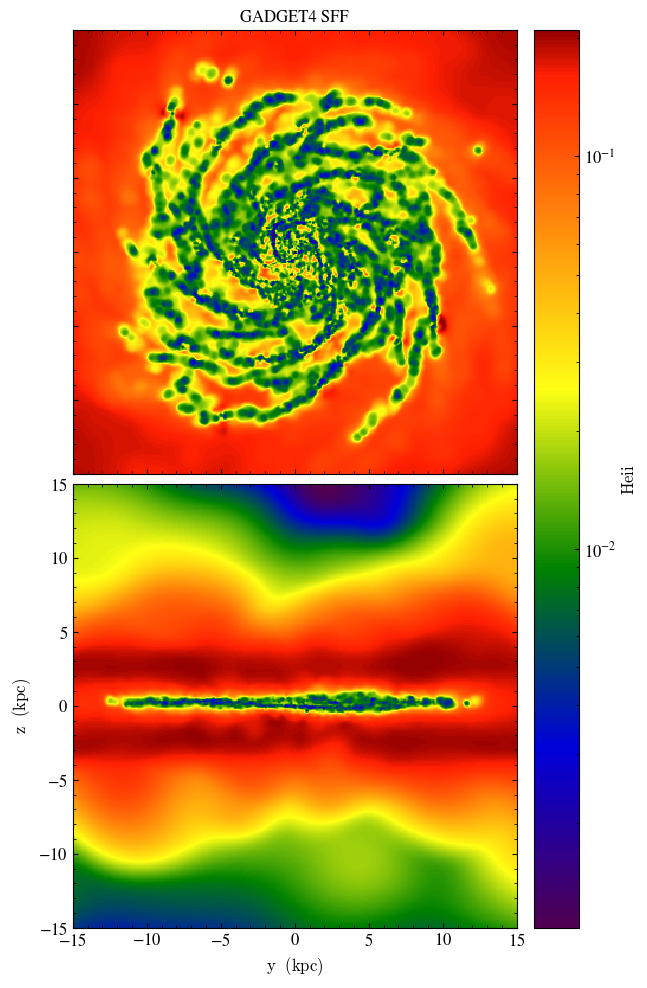

Setup complete - Starting fig making for HeIII
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


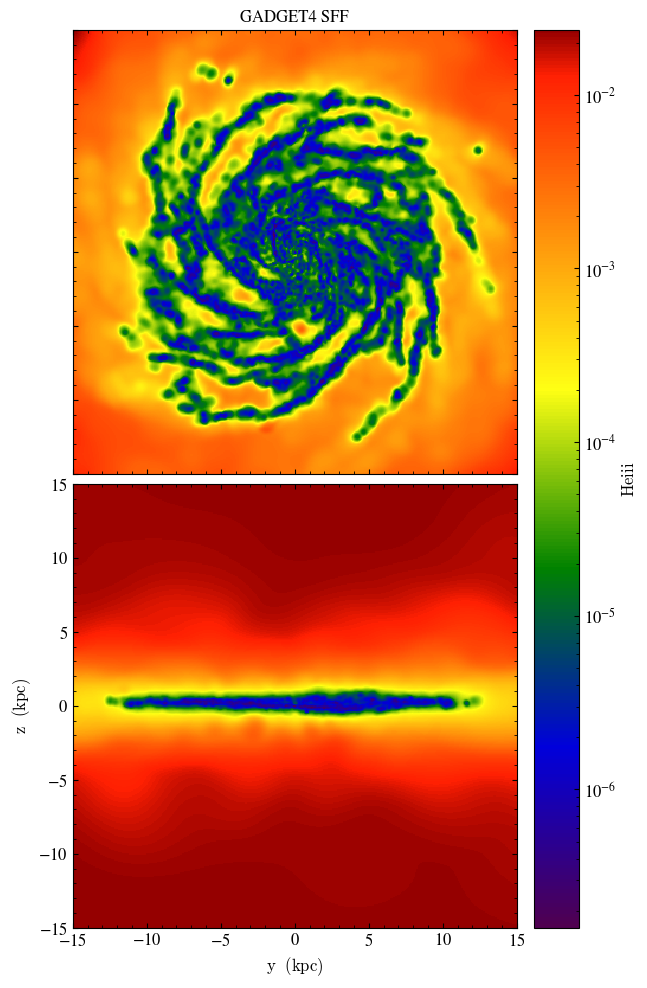

Setup complete - Starting fig making for ElectronAbundance
Projecting GADGET4 SFF in z Time 465.97947087230966 Myr
Projecting GADGET4 SFF in x
Rendering GADGET4 SFF
Showing to screen


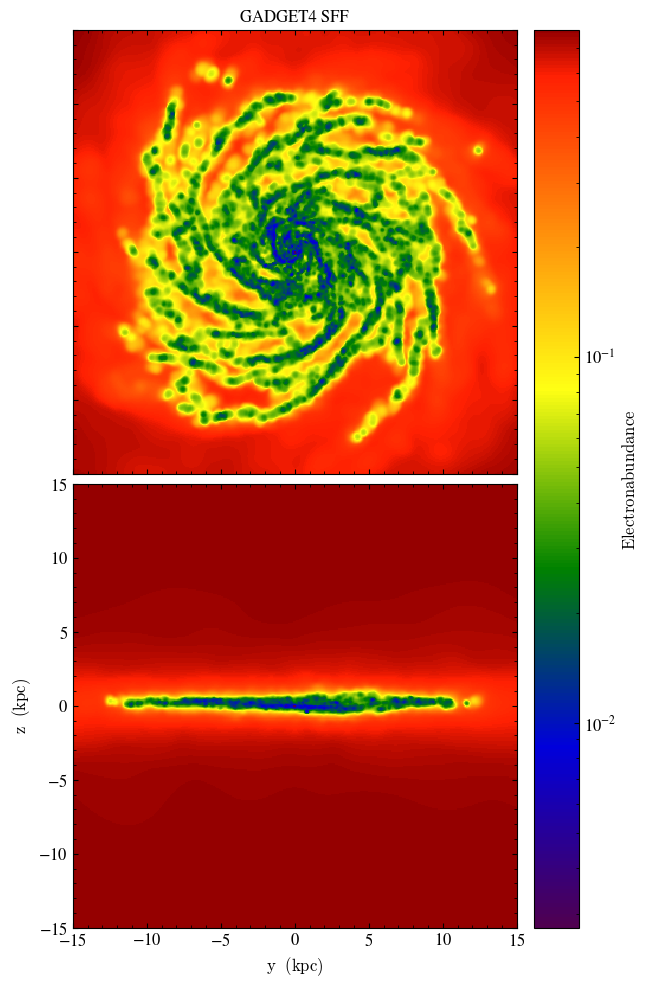

In [41]:
# HI MAP

snapArr  = [sims[i].ytFull[idx[i]] for i in range(len(sims))]
# New fields
def _density_squared(field, data):  
	return data[("gas", "density")]**2
for snap in snapArr:
    snap.add_field(("PartType0", "density_squared"), function=_density_squared, units="g**2/cm**6", sampling_type="particle")

ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HI",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HII",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="H2I",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="H2II",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HDI",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HM",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HeI",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HeII",wField="density_squared",zFieldUnit=0,zFieldLim=0)
ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="HeIII",wField="density_squared",zFieldUnit=0,zFieldLim=0)

ytProjPanel([simsSFF[1]],[idxSFF[1]],zField="ElectronAbundance",wField="density_squared",zFieldUnit=0,zFieldLim=0)


yt : [INFO     ] 2025-02-28 20:59:01,734 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2025-02-28 20:59:01,744 Parameters: current_time              = 0.5113556981086731
yt : [INFO     ] 2025-02-28 20:59:01,746 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2025-02-28 20:59:01,747 Parameters: domain_left_edge          = [-2000. -2000. -2000.]
yt : [INFO     ] 2025-02-28 20:59:01,748 Parameters: domain_right_edge         = [2000. 2000. 2000.]
yt : [INFO     ] 2025-02-28 20:59:01,750 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-02-28 20:59:01,766 Parameters: current_time              = 34.5405400000315
yt : [INFO     ] 2025-02-28 20:59:01,766 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2025-02-28 20:59:01,767 Parameters: domain_left_edge          = None
yt : [INFO     ] 2025-02-28 20:59:01,768 Parameters: domain_right_edge         = None
yt : [INFO     ] 2025-02-28 20:59:01,769 Parameters: cosmological_sim

OSError: Sizes do not agree in the header and footer for this record - check header dtype

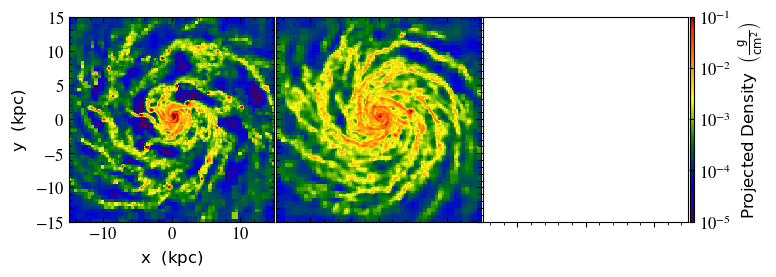

In [4]:
# OLD OCTREE (use venv 3.7.7)
import yt
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import copy

#import matplotlib
#matplotlib.use('Agg')

gadget_base = {'UnitLength_in_cm': 3.08568e+21, 'UnitMass_in_g': 1.989e+43,	'UnitVelocity_in_cm_per_s': 100000}
bbox        = [[-2000.0, 2000.0], [-2000.0, 2000.0], [-2000.0, 2000.0]]

ytG3sff   = yt.load("C:\Home\Astro\AGORA\isolated\G3 data\snap_iso_sf_010.hdf5",unit_base=gadget_base,bounding_box=bbox,n_ref=64,over_refine_factor=1)     # G3 SFF 
ytCHANGA  = yt.load("C:\Home\Astro\AGORA\isolated\CHANGA data\disklow.000500",unit_base=gadget_base,n_ref=64,over_refine_factor=1)     # CHANGA SFF 
ytRAMSES  = yt.load("C:\Home\Astro\AGORA\isolated\RAMSES data\output_00216\info_00216.txt") # RAMSES SFF

pfL = [ytG3sff,ytCHANGA,ytRAMSES]
part = "gas"

panSize = len(pfL)

pltFig = plt.figure(figsize=(100,20))
pltAx  = AxesGrid(pltFig, (0.01,0.01,0.99,0.99), nrows_ncols = (1, panSize), axes_pad = 0.02, add_all = True, share_all = True,
						  label_mode = "1", cbar_mode = "single", cbar_location = "right", cbar_size = "2%", cbar_pad = 0.02)

cenArr = [[0.1, -0.1, 0.1],[0.01, -0.05, 0.2],[0.01, -0.05, 0.2]]
for i in range(panSize):
    pf = pfL[i]
    
    # FIND CENTER AND PROJ_REGION
    #v, cen = pf.h.find_max((part, "density")) # find the center to keep the galaxy at the center of all the images; here we assume that the gas disk is no bigger than 30 kpc in radius
    #sp = pf.sphere(cen, (30.0, "kpc")) 
    #cen2 = sp.quantities.center_of_mass(use_gas=True, use_particles=False).in_units("kpc")
    #sp2 = pf.sphere(cen2, (1.0, "kpc"))
    #cen3 = sp2.quantities.max_location((part, "density"))
    #center = pf.arr([cen3[1].d, cen3[2].d, cen3[3].d], 'code_length')
    #print(np.array(center.in_units("kpc"))[:])
    
    proj_region = pf.all_data()

    cenProc = np.array(cenArr[i])
    fig1 = yt.ProjectionPlot(pf, "z", (part,"density"), fontsize=12, width=(30,"kpc"), center=cenProc,data_source=proj_region, weight_field=None, window_size=4, max_level=2e1)
    fig1.set_unit(("gas", "density"), "g/cm**2")
    fig1.set_zlim(("gas", "density"), zmin=1e-5, zmax=1e-1)

    my_cmap = copy.copy(plt.cm.get_cmap('algae'))
    my_cmap.set_bad(my_cmap(0)) # cmap range [0, 1)
    my_cmap.set_under(my_cmap(0))
    
    fig1.set_cmap(field=(part, "density"), cmap="algae")
    #fig1.set_buff_size(800)
    
    plot1 = fig1.plots[part,"density"]
    plot1.figure = pltFig
    plot1.axes   = pltAx[i].axes
    if i == 0: plot1.cax = pltAx.cbar_axes[0]

    fig1._setup_plots()

plt.show()
#pltFig.savefig("test2", bbox_inches='tight', pad_inches=0.03, dpi=300)


In [ ]:
# EXACT SAME PAPER II SCRIPT TRY 
import matplotlib
matplotlib.use('Agg')
import sys
import math
import copy
import csv
import numpy as np
import matplotlib.colorbar as cb
import matplotlib.lines as ln
import yt.utilities.physical_constants as constants
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from yt.mods import *
from yt.units.yt_array import YTQuantity
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox    import AnchoredText
from matplotlib.ticker import MaxNLocator
from yt.fields.particle_fields import add_volume_weighted_smoothed_field
from yt.fields.particle_fields import add_nearest_neighbor_field
from yt.analysis_modules.star_analysis.api import StarFormationRate
from yt.analysis_modules.halo_analysis.api import *
from yt.data_objects.particle_filters import add_particle_filter
#from scipy.stats import kde
from subprocess import call
mylog.setLevel(0)

figure_width                     = 100            # in kpc
n_ref                            = 32             # for SPH codes
over_refine_factor               = 1             # for SPH codes

gadget_default_unit_base = {'UnitLength_in_cm'         : 3.08568e+21,
			    'UnitMass_in_g'            :   1.989e+43,
			    'UnitVelocity_in_cm_per_s' :      100000}

color_names              = ['red', 'magenta', 'orange', 'gold', 'green', 'cyan', 'blue', 'blueviolet', 'black']
linestyle_names          = ['-']
marker_names             = ['s', 'o', 'p', 'v', '^', '<', '>', 'h', '*']

file_location = ["C:\Home\Astro\AGORA\isolated\G3 data\\"]
codes = ['ART-I', 'ART-II', 'ENZO', 'RAMSES', 'CHANGA', 'GASOLINE', 'GADGET-3', 'GEAR', 'GIZMO']
filenames = [file_location[0]+'snap_iso_sf_010.hdf5']*len(codes)

fig_density_map             = [] 
grid_density_map            = []

#codes = ["GADGET-3"]
times = [500]

print("Setup complete, initiating plot calculations...")
for time in range(len(times)):
	fig_density_map      += [plt.figure(figsize=(100,20))]
	grid_density_map     += [AxesGrid(fig_density_map[0],(0.01,0.01,0.99,0.99),nrows_ncols = (2, len(codes)), axes_pad = 0.02, add_all = True, share_all = True,label_mode = "1", cbar_mode = "single", cbar_location = "right", cbar_size = "2%", cbar_pad = 0.02)]

	for code in range(len(codes)):
		print("- Code",codes[code])
		if codes[code] in "GADGET-3": continue
		print("  Calculations start")
		pf = load(filenames[0], unit_base = gadget_default_unit_base, bounding_box=[[-2000.0, 2000.0], [-2000.0, 2000.0], [-2000.0, 2000.0]], n_ref=n_ref, over_refine_factor=over_refine_factor)

		PartType_Gas_to_use = "PartType0"				
		PartType_Star_to_use = "PartType4"				
		PartType_StarBeforeFiltered_to_use = "PartType4"
		MassType_to_use = "Masses"

		pf.coordinates.x_axis[1] = 0
		pf.coordinates.y_axis[1] = 2
		pf.coordinates.x_axis['y'] = 0
		pf.coordinates.y_axis['y'] = 2

		# FIND CENTER AND PROJ_REGION
		v, cen = pf.h.find_max(("gas", "density")) # find the center to keep the galaxy at the center of all the images; here we assume that the gas disk is no bigger than 30 kpc in radius
		sp = pf.sphere(cen, (30.0, "kpc")) 
		cen2 = sp.quantities.center_of_mass(use_gas=True, use_particles=False).in_units("kpc")
		sp2 = pf.sphere(cen2, (1.0, "kpc"))
		cen3 = sp2.quantities.max_location(("gas", "density"))
		center = pf.arr([cen3[1].d, cen3[2].d, cen3[3].d], 'code_length') # naive usage such as YTArray([cen3[1], cen3[2], cen3[3]]) doesn't work somehow for ART-II data

		proj_region = pf.all_data()

		# DENSITY PLOT
		my_cmap = copy.copy(matplotlib.cm.get_cmap('algae'))
		my_cmap.set_bad(my_cmap(0)) # cmap range [0, 1)
		my_cmap.set_under(my_cmap(0))
		print("  Initial calculations finished")
		for ax in range(1, 3):  
			print("  Projecting on ax",ax)
			p = ProjectionPlot(pf, ax, ("gas", "density"), data_source=proj_region, width = (figure_width, 'kpc'), weight_field = None, fontsize=9)
			p.set_zlim(("gas", "density"), 1e-5, 1e-1)			
			p.set_cmap(("gas", "density"), my_cmap)
			print("    Finished projection on ax",ax)
			print("    Setting up matplotlib plot")
			plot = p.plots[("gas", "density")]

			plot.figure = fig_density_map[time]
			plot.axes = grid_density_map[time][(ax-1)*len(codes)+code].axes
			if code == 6: plot.cax = grid_density_map[time].cbar_axes[0]
			p._setup_plots()
			print("    Finished setup")
		
		at = AnchoredText("%s" % codes[code], loc=2, prop=dict(size=6), frameon=True)
		grid_density_map[time][code].axes.add_artist(at)
	print("Starting saving procces")
	fig_density_map[time].savefig("Figures\DensityMultipanel_%dMyr" % times[time], bbox_inches='tight', pad_inches=0.03, dpi=300)
	print("Finished saving, happy plotting!")

c:\Home\Astro\AGORA\.venv\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: The star_analysis module has been deprecated. This code has been moved to the yt attic (https://github.com/yt-project/yt_attic) and will be removed in a future release.
c:\Home\Astro\AGORA\.venv\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Development of the HaloCatalog module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.


Setup complete, initiating plot calculations...


- Code ART-I
- Code ART-II
- Code ENZO
- Code RAMSES
- Code CHANGA
- Code GASOLINE
- Code GADGET-3
  Calculations start
  Initial calculations finished
  Projecting on ax 1
    Finished projection on ax 1
    Setting up matplotlib plot
    Finished setup
  Projecting on ax 2
    Finished projection on ax 2
    Setting up matplotlib plot
    Finished setup
- Code GEAR
- Code GIZMO
Starting saving procces
Finished saving, happy plotting!
